# Performance assessment with PRECIPITATION in ARPEGE-Climat PPE

<a id="top">This code</a> is assessing model performance based on Precipitation (pr) within the ARPEGE_Climat Perturbed Physics Ensemble. The metric is then used together with emulators (Multi Linear Regression) to constrain the feedback distribution in the ensemble, but also to study a subset of optimal parameter chosen with the total metric $E_{tot}$ and simulated with ARPEGE-Climat 6.3. <br> 

## It is a 6 steps method : 
### [Step 1 - EOF analysis](#EOF)
### [Step 2 - MultiLinReg predictions](#emulator)
### [Step 3 - Projection of observation dataset](#observation)
### [Step 4 - RMSE estimate](#RMSE)
### [Figure histograms](#histograms)
### [Step 5 - Optimisation](#optim)
### [Step 6 - Optimal subset of parameters](#selection)
### [Check correlation with simple RMSE](#correl)

# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Settings

### Variables

In [2]:
variables = ['pr']
variable = 'pr'
TITLE = 'Precipitation'
ylabel = '$E_{pr}$ (mm/day)'

### Paths

In [53]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'

### List of members

In [118]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# <a id="EOF">Step 1 - EOF analysis</a> </li>

For each variable, we consider the climatological mean of the model outputs and we calculate empirical orthogonal functions (EOFs) of the control mean states of the ensemble. In contrast to conventional EOFs, the temporal dimension is replaced by the ensemble itself. This analysis provides a compact description of the spatial and temporal variability of the ensemble variance control climate in term of orthogonal functions, or statistical "modes". The resulting EOFs are spatial patterns, while their principal components ($PCs$) are the expansion coefficients showing the amplitude of the EOF in each ensemble member.

### Functions

In [5]:
def get_3D_pr_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    pr = df['pr']*86400 
    #
    return pr

In [6]:
def eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure):
    # Plot the EOF map 

    lat = data['lat'][:]
    lon = data['lon'][:]

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()

    eof = eof_nb-1
    data = data[eof]
    ax.set_title(title, fontsize=18, fontweight = 'bold')

    m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
    x, y = m(*np.meshgrid(lon,lat))


    cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

    m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
    #m.colorbar()
    cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
    cbar.set_label(' ', size = 16, style = 'italic')

    m.drawcoastlines()
    m.drawmapboundary()
    plt.clim(label_min, label_max)

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

In [7]:
def pc_plot(data, pc_nb, ymin, ymax, title, name_figure):
    #pc = solver.pcs(pcscaling=1)
    #pc = pc*-1

    # Plot the leading PC time series.
    plt.figure(figsize=(10, 5))
    
    pc = pc_nb - 1
    data[:, pc].plot(color='black', linewidth=2)
    ax = plt.gca()
    ax.axhline(0, color='k', alpha=0.5)
    #ax.axvline(x=(8+1), color='red', alpha=0.5)
    #ax.axvline(x=(11+1), color='red', alpha=0.5)
    #ax.axvline(x=(23+1), color='red', alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Members', size = 16)
    ax.set_ylabel('Normalized Units', size = 16)
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

### Get the data

In [132]:
# Official
path = path_official
filename = '*_CNRM-CM6-1_amip_*.nc'
official_amip = get_3D_pr_xarr(path, filename, variables)

# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_pr_xarr(path, filename, variables)

In [133]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_pr_xarr(path, filename, variables)
    i=i+1  

In [134]:
#amip['official'] = official_amip
amip['p1'] = p1_amip

### Create EOF input matrix

In [135]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

#amip_list[0] = amip['official']
amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    #j=i+1
    amip_list[i+1] = tmp
    i+=1

In [136]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])
matrix

<xarray.DataArray 'pr' (time: 103, lat: 128, lon: 256)>
dask.array<concatenate, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

### EOF analysis

In [137]:
# Mean wheigted with cos(lat) : 
lats = matrix['lat'][:]
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat).drop(labels='height').values
W =wgts[np.newaxis,:,np.newaxis]
#W

In [138]:
list_tmp = W[0,:,0]
list_W = []
list_lat = []
list_lon = []
list_mb = []

for j in range(0,256,1) :
    for i in range(0,128,1) :
        list_W.append(list_tmp[i])
        list_lat.append(float(amip['p1']['lat'][i]))
        list_lon.append(float(amip['p1']['lon'][j]))
        #list_mb.append(k)

In [139]:
df = pd.DataFrame(list_W, columns=['W'])#.transpose()
df['lat'] = list_lat
df['lon'] = list_lon
#df['dummy'] = list_dummy
df_W = df.groupby(['lat','lon']).mean().to_xarray()
da_W = df_W.to_array(dim='time')
#df_W = df.drop(dims='variable')
df_W['W']

<xarray.DataArray 'W' (lat: 128, lon: 256)>
array([[0.13679714, 0.13679714, 0.13679714, ..., 0.13679714, 0.13679714,
        0.13679714],
       [0.20723052, 0.20723052, 0.20723052, ..., 0.20723052, 0.20723052,
        0.20723052],
       [0.25940918, 0.25940918, 0.25940918, ..., 0.25940918, 0.25940918,
        0.25940918],
       ...,
       [0.25940918, 0.25940918, 0.25940918, ..., 0.25940918, 0.25940918,
        0.25940918],
       [0.20723052, 0.20723052, 0.20723052, ..., 0.20723052, 0.20723052,
        0.20723052],
       [0.13679714, 0.13679714, 0.13679714, ..., 0.13679714, 0.13679714,
        0.13679714]])
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6

In [16]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'pr' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

In [18]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
#mean_df

anom_df =  anom.to_dataframe(name=str(variables[0])+'mean').drop(labels = 'height', axis=1)
#anom_df

In [19]:
anom_w = (anom*df_W)#.to_array()
anom_w['W']

<xarray.DataArray 'W' (time: 103, lat: 128, lon: 256)>
dask.array<mul, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    height   float64 2.0
Dimensions without coordinates: time

In [20]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w['W'], center=False, weights=None)

eof = solver.eofsAsCovariance(neofs=100, pcscaling=0)
pc = solver.pcs(npcs=100, pcscaling=0)

In [21]:
varFrac = solver.varianceFraction(neigs=10)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 10)>
array([0.28023055, 0.17486766, 0.08545674, 0.05723267, 0.04353731,
       0.03211438, 0.02572518, 0.02261979, 0.01882574, 0.01435854])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  variance_fractions

### EOF 1 : plotting 

In [23]:
varFrac_list = []
for i in varFrac.values :
    tmp = round(i, 2)
    varFrac_list.append(tmp)
varFrac_list

[0.28, 0.17, 0.09, 0.06, 0.04, 0.03, 0.03, 0.02, 0.02, 0.01]

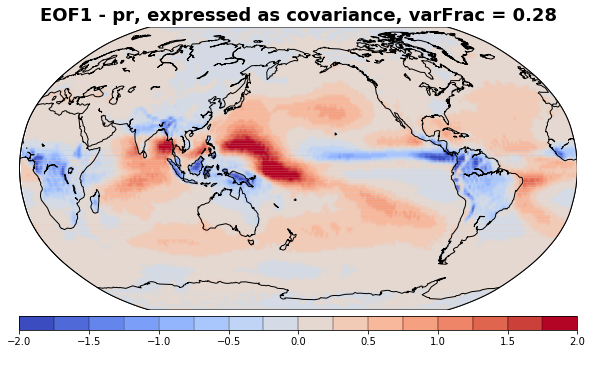

In [24]:
data = eof*(-1)
eof_nb = 1
title = "EOF1 - "+str(variables[0])+", expressed as covariance, varFrac = "+str(varFrac_list[0])
label_min = -2
label_max = 2
name_figure = "PPE2_EOF1map_"+str(variable)+".png"
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [25]:
EOF1_df = eof[0].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF1_df.to_pickle("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_"+str(variable)+".npy")

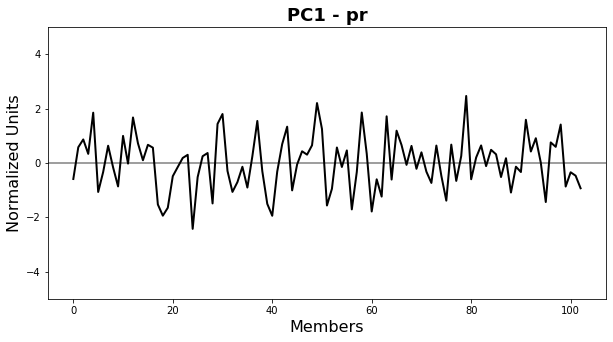

In [26]:
data = pc*(-1)
pc_nb = 1
ymin = -5
ymax = 5
title = "PC1 - "+str(variables[0])
name_figure = "PPE2_EOF1pc_"+str(variables[0])+".png"
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 2 : plotting 

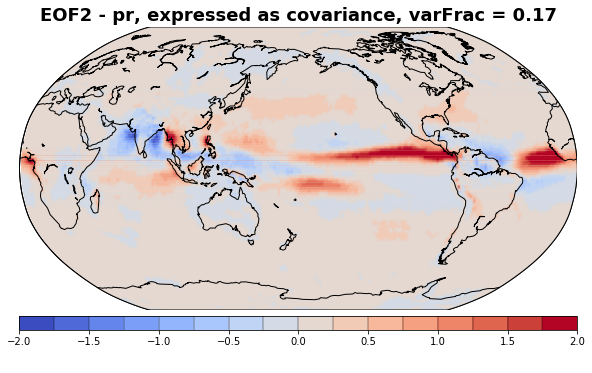

In [28]:
data = eof*(-1)
eof_nb = 2
title = "EOF2 - "+str(variables[0])+", expressed as covariance, varFrac = "+str(varFrac_list[1])
label_min = -2
label_max = 2
name_figure = 'PPE2_EOF2map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [29]:
EOF2_df = eof[1].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF2_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+str(variable)+'.npy')

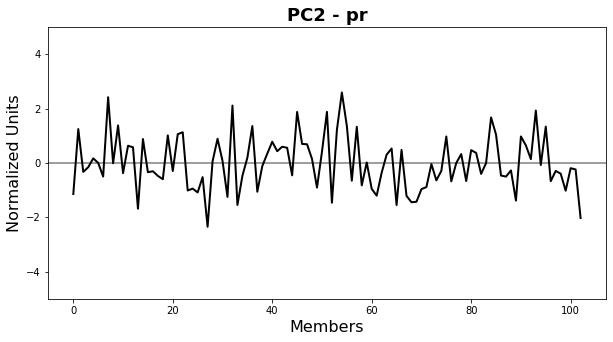

In [30]:
data = pc*(-1)
pc_nb = 2
ymin = -5
ymax = 5
title = 'PC2 - '+str(variable)
name_figure = 'PPE2_EOF2pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 3 : plotting

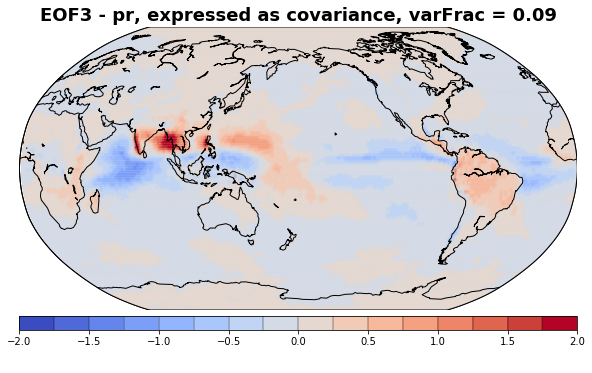

In [31]:
data = eof*(-1)
eof_nb = 3
title = 'EOF3 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[2])
label_min = -2
label_max = 2
name_figure = 'PPE2_EOF3map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [32]:
EOF3_df = eof[2].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF3_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+str(variable)+'.npy')

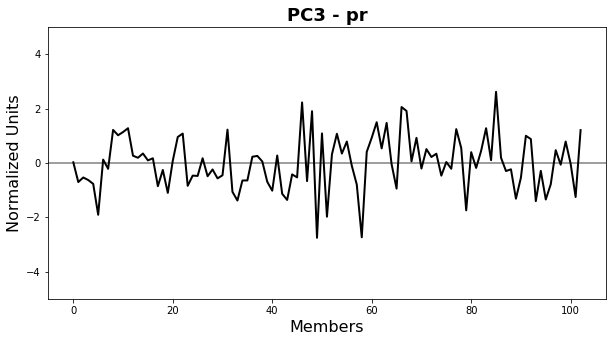

In [33]:
data = pc*(-1)
pc_nb = 3
ymin = -5
ymax = 5
title = 'PC3 - '+str(variable)
name_figure = 'PPE2_EOF3pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 4 : plotting 

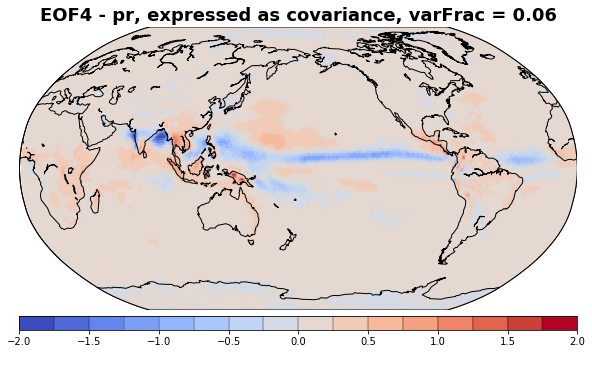

In [34]:
data = eof
eof_nb = 4
title = 'EOF4 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[3])
label_min = -2
label_max = 2
name_figure = 'PPE2_EOF4map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [35]:
EOF4_df = eof[3].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF4_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+str(variable)+'.npy')

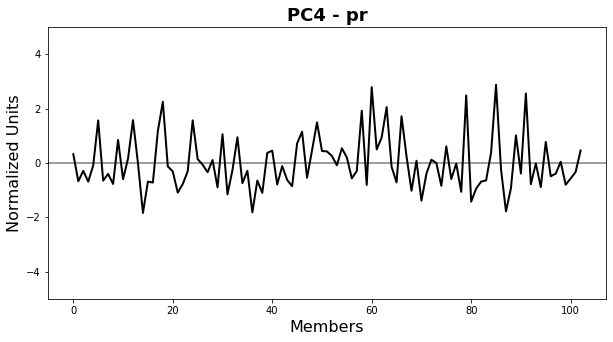

In [36]:
data = pc
pc_nb = 4
ymin = -5
ymax = 5
title = 'PC4 - '+str(variable)
name_figure = 'PPE2_EOF4pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 5 : plotting 

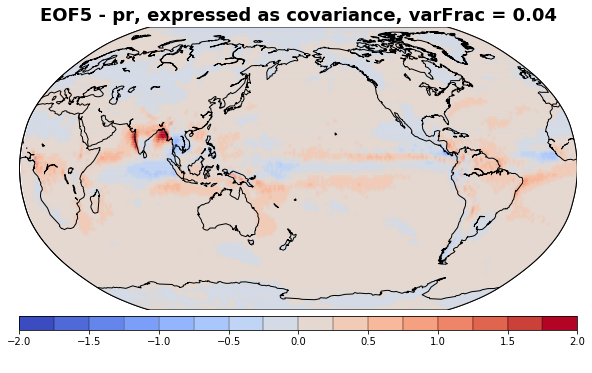

In [37]:
data = eof
eof_nb = 5
title = 'EOF5 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[4])
label_min = -2
label_max = 2
name_figure = 'PPE2_EOF5map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [38]:
EOF5_df = eof[4].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF5_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+str(variable)+'.npy')

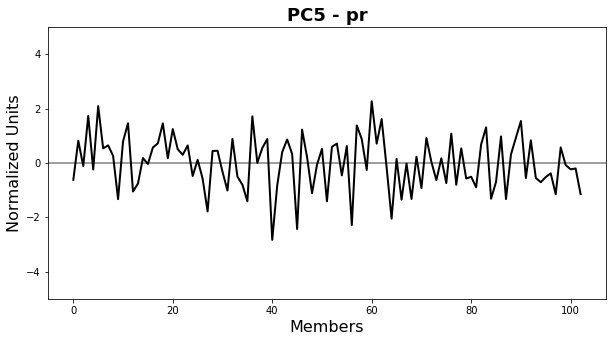

In [39]:
data = pc
pc_nb = 5
ymin = -5
ymax = 5
title = 'PC5 - '+str(variable)
name_figure = 'PPE2_EOF5pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### Save data

In [22]:
#pc1_official = pc[0, 0]
pc1_p1 = pc[0, 0]

pc1 = pc[1:, 0]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF1pc_'+str(variable)+'.npy', pc1_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_'+str(variable)+'.npy', pc1_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+str(variable)+'.npy', pc1)

In [23]:
#pc2_official = pc[0,1]
pc2_p1 = pc[0,1]
pc2 = pc[1:, 1]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF2pc_'+str(variable)+'.npy', pc2_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_'+str(variable)+'.npy', pc2_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+str(variable)+'.npy', pc2)

In [24]:
#pc3_official = pc[0,2]
pc3_p1 = pc[0,2]
pc3 = pc[1:, 2]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF3pc_'+str(variable)+'.npy', pc3_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_'+str(variable)+'.npy', pc3_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+str(variable)+'.npy', pc3)

In [25]:
#pc4_official = pc[0, 3]
pc4_p1 = pc[0, 3]
pc4 = pc[1:, 3]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF4pc_'+str(variable)+'.npy', pc4_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_'+str(variable)+'.npy', pc4_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+str(variable)+'.npy', pc4)

In [26]:
#pc5_official = pc[0, 4]
pc5_p1 = pc[0, 4]
pc5 = pc[1:, 4]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF5pc_'+str(variable)+'.npy', pc5_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_'+str(variable)+'.npy', pc5_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+str(variable)+'.npy', pc5)

In [27]:
## varFrac

# Save the numpy array in a file   
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_varFrac_'+str(variable)+'.npy', varFrac)

In [28]:
# Save the Mean and Anom numpy arrays in a file  

mean_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+str(variable)+'_mean.npy')
anom_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+str(variable)+'_anom.npy')

### [Back to the top](#top)

# <a id="emulator">Step 2 - MultiLinReg predictions</a> </li>

Use of statistical emulators to predict, based on the perturbed parameter values, ARPEGE-Climat's outputs. The emulators must predict both the climate control mean state (here the global mean tas) and the global net feedback (in another code).  


The emulator is a simple multi linear regression model built and trained to predict the five first $PCs$ of the EOF analysis estimated in [Step 1](#EOF). It is expressed as followed : 
\begin{equation}
    Y = \Sigma_{j=1}^K a_jx_j + R 
    \label{eq_emulator}
\end{equation}

with $Y = PC_i$ the PC of one mode of the EOF analysis ($i=5$), $x_j$ the parameter values, $a_j$ the regression coefficients estimated based on the training of the model, $R$ the intercept and $K=30$ the number of perturbed parameter.

### Functions

In [29]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions_emulation
from Fonctions_emulation import Lasso_tunage
from Fonctions_emulation import Lasso_model
from Fonctions_emulation import plot_model_skill
from Fonctions_emulation import plot_model_skill_lines
from Fonctions_emulation import Lasso_pred
from Fonctions_emulation import MultiLinReg_model
from Fonctions_emulation import MultiLinReg_pred

### EOF 1 - prediction

In [30]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [31]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.39860406944417687
Coefficients: 
 [-22.92044822 -29.88095517 -19.03056355  -4.85675702   5.3082437
 -22.40432998  -2.94796493   4.71205033 -19.24479856  -4.69529375
   8.78271903   4.18517815 -16.77363184  -9.51241267  17.45137893
   2.33947207  -4.97070985  -6.68945691  -0.63029691   9.5556836
  -0.17849849   1.10373727 -20.06176556 -11.47428127   2.65777352
   0.63285306  -5.82712546  -2.30381815 -17.61724813  -6.45265642]
Score: 
 0.8763334093726969


,y_true,y_eq,members,members_0
0,-39.641038,-24.032503,p311,0
1,-59.308941,-50.882246,p312,1
2,-22.841644,-8.687323,p314,2
3,-127.004260,-84.749346,p316,3
4,73.567028,73.680005,p317,4
...,...,...,...,...
97,-97.054192,-50.234168,p465,97
98,59.813746,19.948001,p467,98
99,23.685482,30.934007,p469,99
100,32.340656,54.901272,p470,100


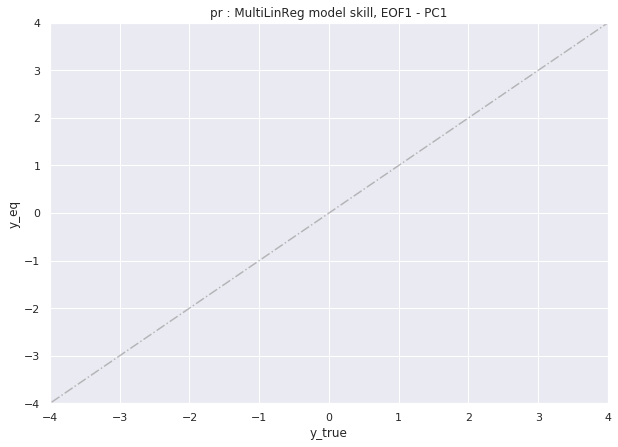

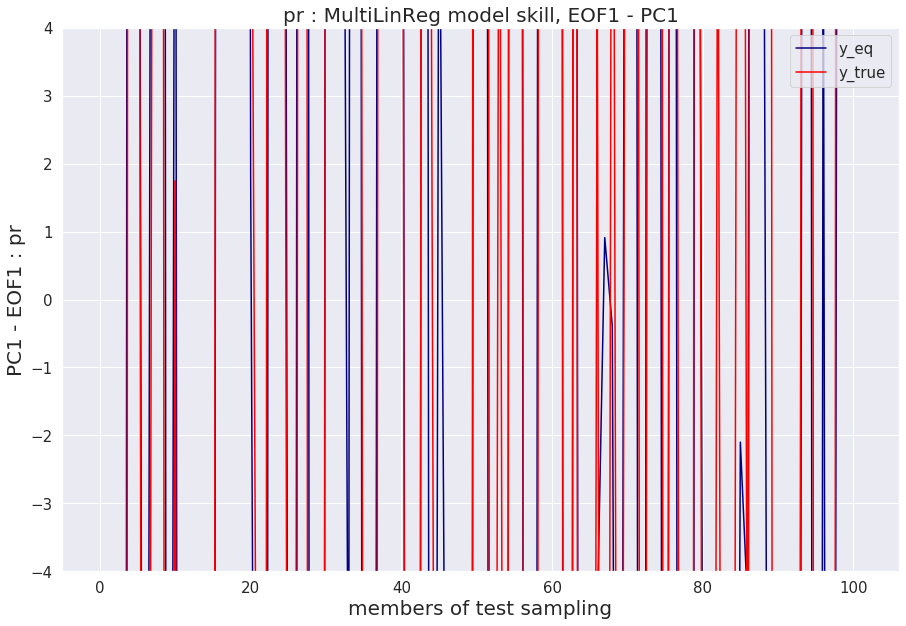

In [32]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF1 - PC1'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc1.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC1 - EOF1 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [33]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,46.078080,102.0
1,75.313640,103.0
2,-36.349246,104.0
3,-7.868295,105.0
4,2.317954,106.0
...,...,...
99995,-26.830943,100097.0
99996,-39.157564,100098.0
99997,25.194214,100099.0
99998,149.621791,100100.0


#### Save data

In [34]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof1_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof1_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 2 - prediction

In [35]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [36]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.6090744778464117
Coefficients: 
 [-16.12203856 -13.52471034 -13.11088989   1.27180025   0.97472639
  -4.4003096    3.78446841   1.36961559  -0.10891054   4.21348289
   0.56848607  -5.20635176   9.21807047   3.16012515 -19.97075754
  -8.77271257  -0.47229307 -14.64751207  -0.6672572   -7.9873178
   7.58285924  14.5242667   -7.67032335 -14.27729681  -1.64440684
  -1.43326236  -2.8173893    3.67650352   7.6886562  -11.27616596]
Score: 
 0.8089439285005848


,y_true,y_eq,members,members_0
0,-67.600960,-39.611710,p311,0
1,17.939061,8.711640,p312,1
2,8.606309,4.107170,p314,2
3,-9.039118,-1.639811,p316,3
4,-0.094295,-15.855254,p317,4
...,...,...,...,...
97,21.515287,-45.038031,p465,97
98,55.515797,35.181395,p467,98
99,10.585372,46.485814,p469,99
100,13.058195,42.694419,p470,100


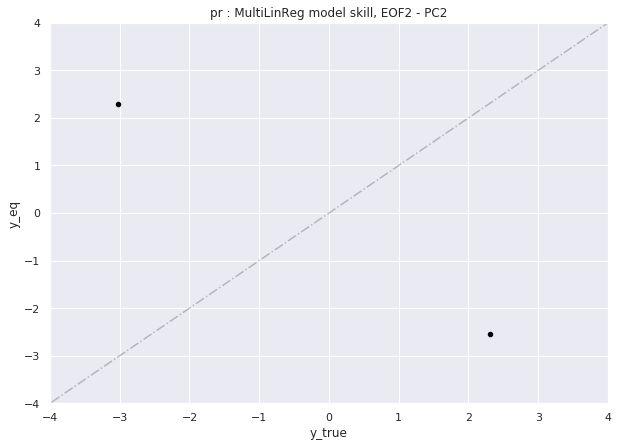

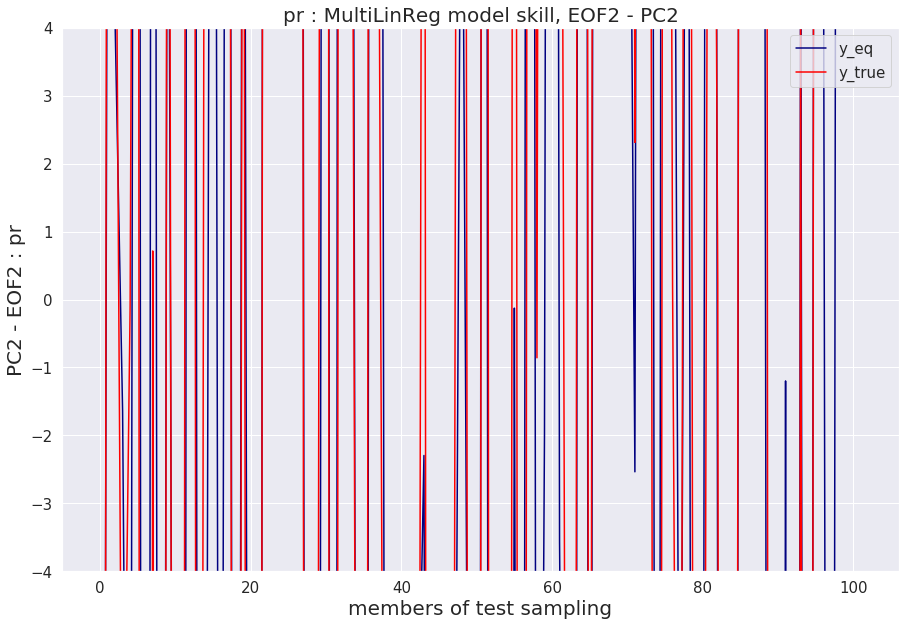

In [37]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF2 - PC2'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc2.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC2 - EOF2 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [38]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,-42.928317,102.0
1,-54.260941,103.0
2,29.123004,104.0
3,-67.360229,105.0
4,-41.121950,106.0
...,...,...
99995,54.361908,100097.0
99996,42.797713,100098.0
99997,-10.937543,100099.0
99998,6.084893,100100.0


#### Save data

In [39]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof2_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof2_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 3 - prediction

In [40]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [41]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.008217275067284792
Coefficients: 
 [  2.53491908  -4.01638591  -9.6106266    2.74810244  -1.39466058
 -16.28102766  -1.38239057   4.27807896   9.74404969   6.49175686
   1.51436092   0.31473977   3.6795658    4.63225057  -0.49902273
  -1.04594412  -4.71960923  -1.06792785  -8.4795323    3.88614802
  -3.84338382   4.22508259   0.14462121  14.05603111   2.53434723
  -4.74501564   0.20018697   5.12645417   2.22708015  -2.55903517]
Score: 
 0.6004652904476941


,y_true,y_eq,members,members_0
0,26.745839,-21.307594,p311,0
1,20.367842,13.502730,p312,1
2,23.933690,44.448060,p314,2
3,29.304957,-4.409135,p316,3
4,72.451824,47.355943,p317,4
...,...,...,...,...
97,2.509981,12.215010,p465,97
98,-29.819833,-42.816488,p467,98
99,1.242809,-12.311002,p469,99
100,47.639314,49.629705,p470,100


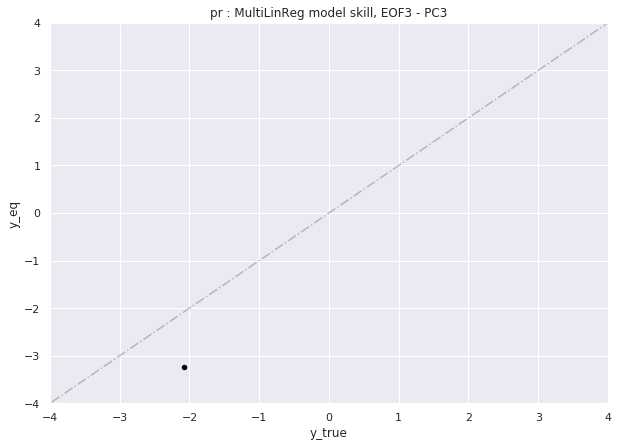

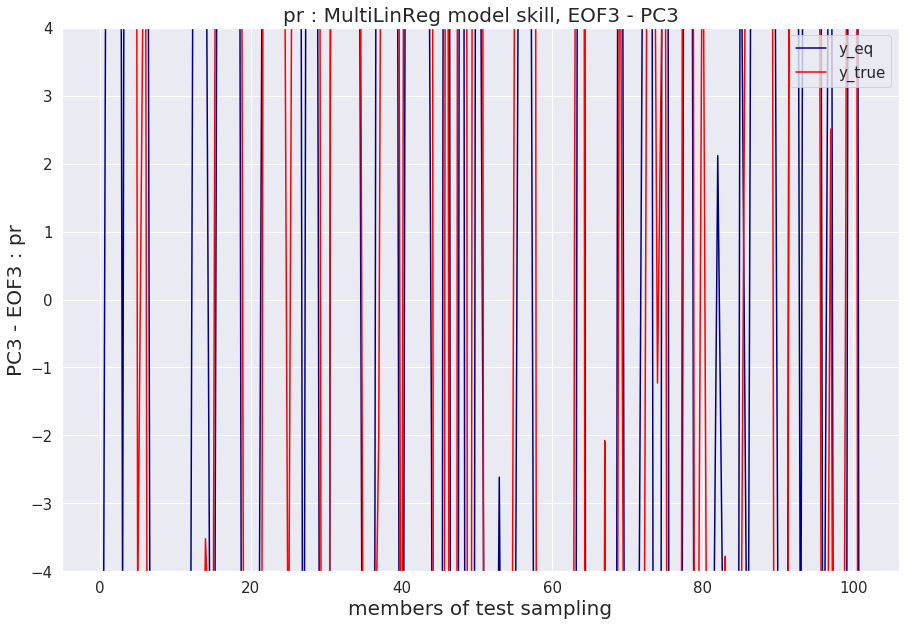

In [42]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF3 - PC3'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc3.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC3 - EOF3 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [43]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,1.138435,102.0
1,-0.765629,103.0
2,19.985074,104.0
3,31.487696,105.0
4,-33.387405,106.0
...,...,...
99995,-23.084645,100097.0
99996,49.474424,100098.0
99997,5.094655,100099.0
99998,56.208768,100100.0


#### Save data

In [44]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof3_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof3_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 4 - prediction

In [45]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [46]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.09783698391314238
Coefficients: 
 [ -0.88396723 -11.69513596  -2.89577099  -0.49637912   3.1196249
  -7.09615741   0.70825836  -7.20579767   5.22221579  -6.24924698
   3.55942814   2.56263339   4.19562492  -3.02538475   0.40871508
   2.53647529  -0.43848447  -1.02282645   4.1433726   -7.15010285
  -0.41870092   5.66411998   7.62628865   3.62896112  -4.69294222
  -0.55735009   0.4569029   -0.92617542   5.0165764    3.7042858 ]
Score: 
 0.5150789874494225


,y_true,y_eq,members,members_0
0,20.957515,6.116057,p311,0
1,9.104649,26.248086,p312,1
2,21.381769,-7.505122,p314,2
3,2.975930,16.284927,p316,3
4,-48.501994,-41.118614,p317,4
...,...,...,...,...
97,-1.262494,5.058152,p465,97
98,24.966084,27.668139,p467,98
99,17.821676,20.392407,p469,99
100,10.395303,17.535346,p470,100


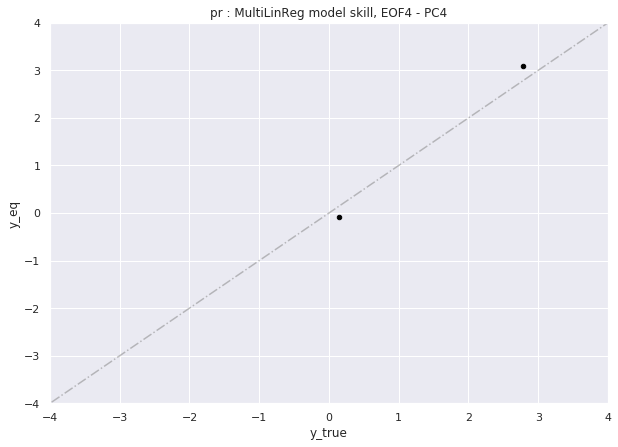

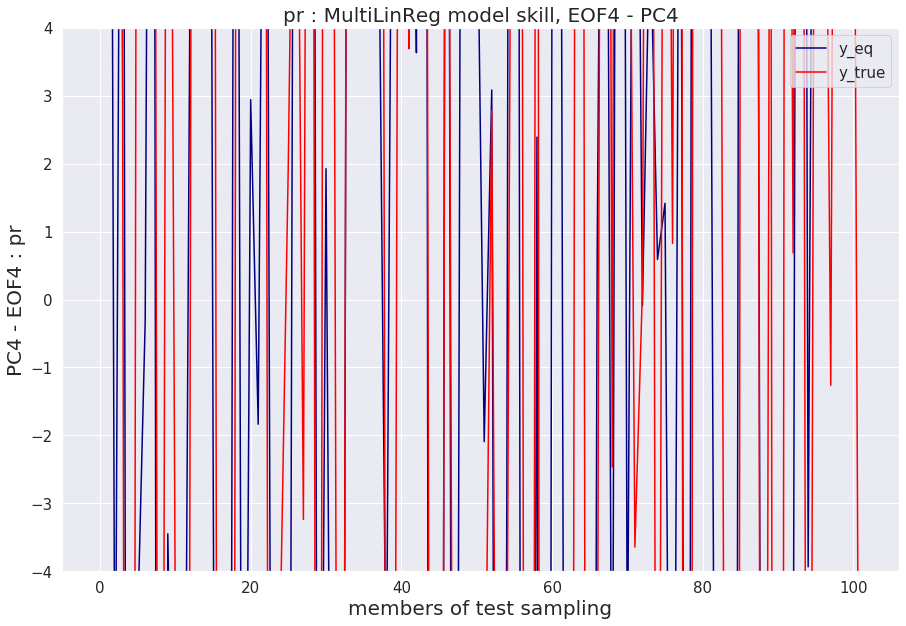

In [47]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF4 - PC4'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc4.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC4 - EOF4 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [48]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,24.401610,102.0
1,28.516289,103.0
2,-10.440888,104.0
3,21.883825,105.0
4,-20.800595,106.0
...,...,...
99995,15.016481,100097.0
99996,46.734312,100098.0
99997,5.456565,100099.0
99998,-7.345779,100100.0


#### Save data

In [49]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof4_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof4_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 5 - prediction

In [50]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [51]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.16508759815166238
Coefficients: 
 [-8.84030825 -4.5925635  -3.12285817  3.2490467   0.22114604  4.54975079
  0.48393344 -4.23326243  1.39319288 -9.57378514  0.75927699  3.72572442
 -4.29013726 -0.51851477 -3.62315286 -5.36512746  1.47393085  5.77519926
  3.83449966  2.41198742 -0.21463122 -5.11414861  0.51772575  5.5228029
  3.58162295  5.30246276 -3.31052052  2.47578232  9.76199315  2.06564432]
Score: 
 0.7558681345969128


,y_true,y_eq,members,members_0
0,-22.195813,-24.262282,p311,0
1,3.244862,0.873068,p312,1
2,-46.843043,-41.076346,p314,2
3,6.573410,-6.004780,p316,3
4,-56.641998,-49.793036,p317,4
...,...,...,...,...
97,-15.473365,16.155088,p465,97
98,2.176767,10.363428,p467,98
99,6.404811,-3.454953,p469,99
100,5.531966,8.494391,p470,100


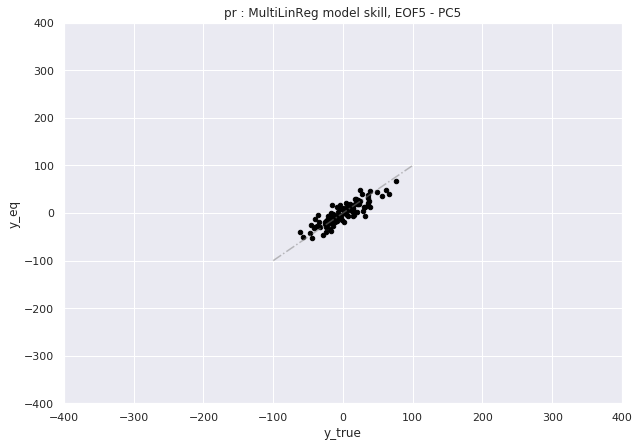

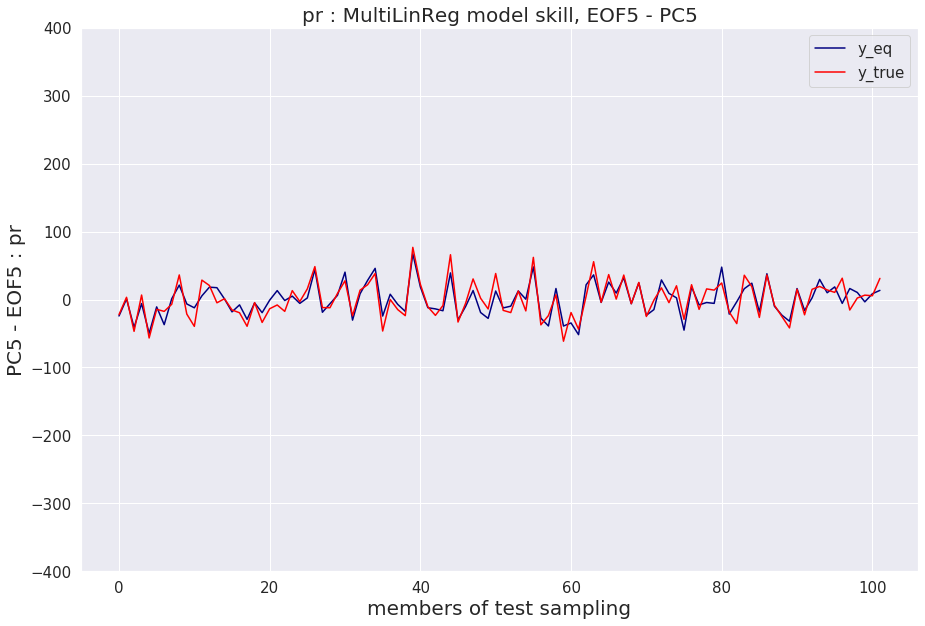

In [55]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF5 - PC5'
xmin = -400
xmax = 400
ymin = -400
ymax = 400
name = 'MultiLinReg_'+variable+'_skill_pc5.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC5 - EOF5 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [53]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,-1.682049,102.0
1,34.103081,103.0
2,-12.658706,104.0
3,5.831653,105.0
4,-9.408198,106.0
...,...,...
99995,32.824055,100097.0
99996,-12.254927,100098.0
99997,0.935194,100099.0
99998,15.478136,100100.0


#### Save data

In [56]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof5_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof5_'+variable+'.npy', 
        MultiLinReg_prediction)

### [Back to the top](#top)

# <a id="observation">Step 3 - Projection of observation dataset</a> </li>

In this section, we project the observations ($X_{obs}$) onto the EOFs calculated in [Step 1](#EOF). We call $U_{ens}$ the ensemble matrix of EOF amplitudes $w$ such as :  

$U_{ens} = \begin{pmatrix} 
                w_{1,1} & w_{2,1} & w_{3,1} & w_{4,1} & w_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                w_{1,102} & w_{2,102} & w_{3,102} & w_{4,102} & w_{5,102}
           \end{pmatrix}$ 
           
           
<br>
<br>
<br>
The ensemble matrix of spatial patterns is called $v_{ens}$ and is expresses such as : 

$v_{ens} = \begin{pmatrix} 
                eof1(lat,lon)  \\ 
                eof2(lat,lon)  \\ 
                eof3(lat,lon)  \\ 
                eof4(lat,lon)  \\ 
                eof5(lat,lon)  \\ 
           \end{pmatrix}$ 


<br>

The EOF analysis can be expresses as : 
$X_{ens} = U_{ens} \cdot v_{ens}$

And we want the EOF amplitudes of the observations within this basis such as : 

$X_{obs} = U_{obs} \cdot v_{ens}$ 

$U_{obs} = X_{obs} \cdot {v_{ens}}^{-1}$

With : 

$U_{obs} = \begin{pmatrix} 
                o_{1,1} & o_{2,1} & o_{3,1} & o_{4,1} & o_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                o_{1,102} & o_{2,102} & o_{3,102} & o_{4,102} & o_{5,102}
           \end{pmatrix}$ 

### Settings

In [57]:
path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/'
filename = 'pr_mon_mean_197901-201912_regrid.nc'
variable_obs = 'pr'

### Functions

In [57]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

### Get the data 

In [59]:
Mean =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
Mean

<xarray.DataArray (lat: 128, lon: 256)>
array([[0.16115941, 0.16115941, 0.16115941, ..., 0.16115941, 0.16115941,
        0.16115941],
       [0.08960055, 0.08960055, 0.08960055, ..., 0.08960055, 0.08960055,
        0.08960055],
       [0.14128352, 0.14128352, 0.14128352, ..., 0.15915012, 0.14128352,
        0.14128352],
       ...,
       [0.70739219, 0.70739219, 0.70739219, ..., 0.64911432, 0.70739219,
        0.70739219],
       [0.64713049, 0.64713049, 0.64713049, ..., 0.64713049, 0.64713049,
        0.64713049],
       [0.55278562, 0.55278562, 0.55278562, ..., 0.55278562, 0.55278562,
        0.55278562]])
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'prmean'

In [61]:
pc1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)

#PC_df

In [62]:
path = path_observation
variables = [variable_obs]
df_obs = load_monthly_clim(path, filename, variables)
df_obs

pr
month lat        lon                
1     -88.927735 0.00000    0.023976
                 1.40625    0.026398
                 2.81250    0.026663
                 4.21875    0.028602
                 5.62500    0.028689
...                              ...
12     88.927735 352.96875  0.397433
                 354.37500  0.384588
                 355.78125  0.384481
                 357.18750  0.382383
                 358.59375  0.382303

[393216 rows x 1 columns]

In [63]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    pr       (lat, lon) float32 0.3159773 0.3089214 ... 0.50588834 0.50602216

In [64]:
## MODIFS essais 08/09/2021
X_obs = obs[variable_obs] - Mean
X_obs_bis = (X_obs*df_W)
U_obs_avg = solver.projectField(X_obs_bis['W'], neofs=5, weighted=False, eofscaling=0)#[0,:]
U_obs_avg

<xarray.DataArray 'pseudo_pcs' (mode: 5)>
array([113.07254454,  75.7049195 ,  -3.93008206, -44.61652539,
        70.86871787])
Coordinates:
  * mode     (mode) int64 0 1 2 3 4
Attributes:
    long_name:  W_pseudo_pcs

### Save data

In [65]:
#Save the U_obs_avg 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy', U_obs_avg)

# Projection of CFMIP data

In [84]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['month']=pd.DatetimeIndex(df1['time']).month # time in years
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    
    return df_mean

In [85]:
# Download the amip dataframes and compute the radiative budget  

path = "/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/"
filename = "*_amip_*.nc"
CNRM_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/MRI-ESM2-0/amip/"
MRI_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/CanESM5/amip/"
filename = "standard_*_amip_*regrid.nc"
CAN_amip = load_monthly_clim(path, filename, variables)
CAN_amip

path = "/data/scratch/globc/peatier/CMIP6/MIROC6/"
filename = "*_amip_*regrid.nc"
MIROC_amip = load_monthly_clim(path, filename, variables)
MIROC_amip

path = "/data/scratch/globc/peatier/CMIP6/HadGEM3-GC31-LL/"
filename = "standard_*_amip_*regrid.nc"
HadGEM3_amip = load_monthly_clim(path, filename, variables)
HadGEM3_amip

path = "/data/scratch/globc/peatier/CMIP6/IPSL-CM6A-LR/"
filename = "*_amip_*regrid.nc"
IPSL_amip = load_monthly_clim(path, filename, variables)
IPSL_amip

path = "/data/scratch/globc/peatier/CMIP6/BCC-CSM2-MR/"
filename = "standard_*_amip_*regrid.nc"
BCC_amip = load_monthly_clim(path, filename, variables)
BCC_amip

pr  height
month lat        lon                        
1     -88.927735 0.00000    0.000002     2.0
                 1.40625    0.000002     2.0
                 2.81250    0.000002     2.0
                 4.21875    0.000002     2.0
                 5.62500    0.000002     2.0
...                              ...     ...
12     88.927735 352.96875  0.000006     2.0
                 354.37500  0.000006     2.0
                 355.78125  0.000006     2.0
                 357.18750  0.000006     2.0
                 358.59375  0.000006     2.0

[393216 rows x 2 columns]

In [86]:
df_obs = pd.DataFrame()
df_obs['CNRM'] = CNRM_amip[variables[0]]
df_obs['MRI'] = MRI_amip[variables[0]]
df_obs['CAN'] = CAN_amip[variables[0]]
df_obs['MIROC'] = MIROC_amip[variables[0]]
df_obs['HadGEM3'] = HadGEM3_amip[variables[0]]
df_obs['IPSL'] = IPSL_amip[variables[0]]
df_obs['BCC'] = BCC_amip[variables[0]]
#df_obs = df_obs.drop(['rsut', 'height'], axis = 1)
df_obs

CNRM       MRI       CAN     MIROC   HadGEM3  \
month lat        lon                                                           
1     -88.927735 0.00000    0.000002  0.000002  0.000002  0.000002  0.000002   
                 1.40625    0.000002  0.000002  0.000002  0.000002  0.000002   
                 2.81250    0.000002  0.000002  0.000002  0.000002  0.000002   
                 4.21875    0.000002  0.000002  0.000002  0.000002  0.000002   
                 5.62500    0.000002  0.000002  0.000002  0.000002  0.000002   
...                              ...       ...       ...       ...       ...   
12     88.927735 352.96875  0.000006  0.000005  0.000006  0.000003  0.000005   
                 354.37500  0.000006  0.000005  0.000006  0.000003  0.000005   
                 355.78125  0.000006  0.000005  0.000006  0.000003  0.000005   
                 357.18750  0.000006  0.000005  0.000006  0.000003  0.000005   
                 358.59375  0.000006  0.000005  0.000006  0.000003  0.000005   

                                IPSL       BCC  
month lat        lon                            
1     -88.927735 0.00000    0.000001  0.000002  
                 1.40625    0.000001  0.000002  
                 2.81250    0.000001  0.000002  
                 4.21875    0.000001  0.000002  
                 5.62500    0.000001  0.000002  
...                              ...       ...  
12     88.927735 352.96875  0.000006  0.000006  
                 354.37500  0.000006  0.000006  
                 355.78125  0.000006  0.000006  
                 357.18750  0.000006  0.000006  
                 358.59375  0.000006  0.000006  

[393216 rows x 7 columns]

In [102]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()*86400 
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    CNRM     (lat, lon) float64 0.1992 0.1992 0.1992 ... 0.6535 0.6535 0.6535
    MRI      (lat, lon) float64 0.1527 0.152 0.1513 ... 0.7101 0.7103 0.7106
    CAN      (lat, lon) float64 0.1428 0.1428 0.1398 ... 0.6491 0.6418 0.6418
    MIROC    (lat, lon) float64 0.104 0.1035 0.1031 ... 0.4774 0.4776 0.4779
    HadGEM3  (lat, lon) float64 0.1668 0.1664 0.1661 ... 0.6522 0.6528 0.6535
    IPSL     (lat, lon) float64 0.1578 0.1551 0.1527 ... 0.6418 0.647 0.6516
    BCC      (lat, lon) float64 0.198 0.1968 0.1956 ... 0.6695 0.6703 0.67

## Compute Anomaly

In [103]:
X_obs = {}
X_obs['CNRM'] = obs['CNRM'] - Mean
X_obs['MRI'] = obs['MRI'] - Mean
X_obs['CAN'] = obs['CAN'] - Mean
X_obs['MIROC'] = obs['MIROC'] - Mean
X_obs['HadGEM3'] = obs['HadGEM3'] - Mean
X_obs['IPSL'] = obs['IPSL'] - Mean
X_obs['BCC'] = obs['BCC'] - Mean
X_obs

{'CNRM': <xarray.DataArray (lat: 128, lon: 256)>
 array([[ 0.03803879,  0.03803879,  0.03803879, ...,  0.03803879,
          0.03803879,  0.03803879],
        [-0.00180562, -0.00180562, -0.00180562, ..., -0.00180562,
         -0.00180562, -0.00180562],
        [ 0.00881006,  0.00881006,  0.00881006, ...,  0.01136503,
          0.00881006,  0.00881006],
        ...,
        [ 0.14970176,  0.14970176,  0.14970176, ...,  0.13433107,
          0.14970176,  0.14970176],
        [ 0.1349773 ,  0.1349773 ,  0.1349773 , ...,  0.1349773 ,
          0.1349773 ,  0.1349773 ],
        [ 0.10075392,  0.10075392,  0.10075392, ...,  0.10075392,
          0.10075392,  0.10075392]])
 Coordinates:
   * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
   * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
     mode     <U6 'prmean', 'MRI': <xarray.DataArray (lat: 128, lon: 256)>
 array([[-0.00846083, -0.0091534 , -0.00983765, ..., -0.00624798,
         -0.00

In [104]:
## MODIFS 08/09/2021

X_obs['CNRM'] = (X_obs['CNRM']*df_W)
U_CNRM_avg = solver.projectField(X_obs['CNRM']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['MRI'] = (X_obs['MRI']*df_W)
U_MRI_avg = solver.projectField(X_obs['MRI']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['CAN'] = (X_obs['CAN']*df_W)
U_CAN_avg = solver.projectField(X_obs['CAN']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['MIROC'] = (X_obs['MIROC']*df_W)
U_MIROC_avg = solver.projectField(X_obs['MIROC']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['HadGEM3'] = (X_obs['HadGEM3']*df_W)
U_HadGEM3_avg = solver.projectField(X_obs['HadGEM3']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['IPSL'] = (X_obs['IPSL']*df_W)
U_IPSL_avg = solver.projectField(X_obs['IPSL']['W'], neofs=5, weighted=False, eofscaling=0)

X_obs['BCC'] = (X_obs['BCC']*df_W)
U_BCC_avg = solver.projectField(X_obs['BCC']['W'], neofs=5, weighted=False, eofscaling=0)

In [105]:
#Save the U_obs_avg 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_CNRM_'+variable+'.npy', U_CNRM_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_MRI_'+variable+'.npy', U_MRI_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_CAN_'+variable+'.npy', U_CAN_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_MIROC_tas.npy', U_MIROC_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_HadGEM3_tas.npy', U_HadGEM3_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_IPSL_tas.npy', U_IPSL_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_BCC_tas.npy', U_BCC_avg)

### [Back to the top](#top)

# <a id="RMSE">Step 4 - RMSE estimate</a> </li>

The model error as compared to observations is calculated by comparing the EOF amplitudes $w$ in each member with the projection of the observations $o$ on the model EOF basis through a Root Mean Square Error (RMSE). For a given member of the PPE, the error associated with the variable $s$ is : 

\begin{equation}
    E_{s} = \sqrt{\Sigma_i^N \frac{(w_{is}-o_{is})^2}{N}}
\end{equation}

with $i$ varying from $1$ to $N$, the number of modes considered. In the present study, we truncated the EOF after the 5th mode for each variable : $N=5$.

### Settings

In [16]:
product = 'GPCP'
ylabel = '$E_{pr}$ ($mm/day$)'
N_error = (128*256)

### Functions

In [17]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/N_error)
    return E

In [18]:
def Error(path, filename, U_obs):
    
    U = np.load(path+filename)

    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]

    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/N_error)
    return E

In [19]:
def RMSE_emulator(pc1, pc2, pc3, pc4, pc5, variable) : 
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    E_pc1 = []
    E_pc2 = []
    E_pc3 = []
    E_pc4 = []
    E_pc5 = []
    E_tmp = []

    for i in pc1:
        tmp = (i-U_obs[0])**2
        E_pc1.append(tmp)
    
    for j in pc2:
        tmp = (j-U_obs[1])**2
        E_pc2.append(tmp)

    for k in pc3:
        tmp = (k-U_obs[2])**2
        E_pc3.append(tmp)
    
    for l in pc4:
        tmp = (l-U_obs[3])**2
        E_pc4.append(tmp)
    
    for m in pc5:
        tmp = (m-U_obs[4])**2
        E_pc5.append(tmp)

    for n in range(0,len(E_pc1),1) :    
        tmp = E_pc1[n]+E_pc2[n]+E_pc3[n]+E_pc4[n]+E_pc5[n]
        E_tmp.append(tmp/N_error)

    
    E = sqrt(E_tmp)
    
    
    return E

### Get the data 

In [20]:
U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')

pc1_obs = U_obs[0]
pc2_obs = U_obs[1]
pc3_obs = U_obs[2]
pc4_obs = U_obs[3]
pc5_obs = U_obs[4]

### p1 default model

In [21]:
pc1_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_'+variable+'.npy')
pc2_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_'+variable+'.npy')
pc3_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_'+variable+'.npy')
pc4_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_'+variable+'.npy')
pc5_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_'+variable+'.npy')

p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

In [22]:
E_p1_tmp = (pc1_p1-pc1_obs)**2 + (pc2_p1-pc2_obs)**2 + (pc3_p1-pc3_obs)**2 + (pc4_p1-pc4_obs)**2 + (pc5_p1-pc5_obs)**2
E_p1 = sqrt(E_p1_tmp/N_error)
        
print(E_p1)

0.5400474976618921


### CMIP6 models

In [23]:
path = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'

filename = 'U_MRI_'+variable+'.npy'
E_MRI = Error(path, filename, U_obs)

filename = 'U_CAN_'+variable+'.npy'
E_CAN = Error(path, filename, U_obs)

filename = 'U_MIROC_'+variable+'.npy'
E_MIROC = Error(path, filename, U_obs)

filename = 'U_HadGEM3_'+variable+'.npy'
E_HadGEM3 = Error(path, filename, U_obs)

filename = 'U_IPSL_'+variable+'.npy'
E_IPSL = Error(path, filename, U_obs)

filename = 'U_BCC_'+variable+'.npy'
E_BCC = Error(path, filename, U_obs)

### PPE

In [24]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_'+variable+'.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+variable+'.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+variable+'.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+variable+'.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+variable+'.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

In [25]:
pc1_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df_PPE = pd.DataFrame(pc1_PPE)
PC_df_PPE['pc1'] = pc1_PPE
PC_df_PPE['pc2'] = pc2_PPE
PC_df_PPE['pc3'] = pc3_PPE
PC_df_PPE['pc4'] = pc4_PPE
PC_df_PPE['pc5'] = pc5_PPE
PC_df_PPE = PC_df_PPE.drop(labels = 0, axis=1)
PC_df_PPE

,pc1,pc2,pc3,pc4,pc5
0,-39.641038,-67.600960,26.745839,20.957515,-22.195813
1,-59.308941,17.939061,20.367842,9.104649,3.244862
2,-22.841644,8.606309,23.933690,21.381769,-46.843043
3,-127.004260,-9.039118,29.304957,2.975930,6.573410
4,73.567028,-0.094295,72.451824,-48.501994,-56.641998
...,...,...,...,...,...
97,-97.054192,21.515287,2.509981,-1.262494,-15.473365
98,59.813746,55.515797,-29.819833,24.966084,2.176767
99,23.685482,10.585372,1.242809,17.821676,6.404811
100,32.340656,13.058195,47.639314,10.395303,5.531966


In [26]:
E_PPE = RMSE_emulator(pc1_PPE, pc2_PPE, pc3_PPE, pc4_PPE, pc5_PPE, variable)
E_PPE

array([1.32766521, 1.119965  , 1.13164155, 1.48562776, 0.94744855,
       0.81765794, 1.5481374 , 0.93300088, 0.92932916, 1.2349035 ,
       1.10822064, 1.41139591, 0.97642699, 1.18181503, 1.0728321 ,
       1.08261304, 0.60778487, 0.68243676, 0.91147456, 0.85151453,
       1.14053995, 1.19590246, 0.96148347, 0.47236239, 0.64875313,
       0.86197672, 0.88775411, 0.67746512, 1.49218025, 1.42805959,
       0.75834874, 1.25415277, 0.57734633, 0.80012214, 0.67065682,
       1.38805374, 1.32606518, 0.90577821, 0.78007861, 0.72339257,
       0.87833263, 1.21851332, 1.45313725, 0.70611448, 1.1657074 ,
       1.24241938, 1.1216421 , 1.09128551, 1.6312465 , 1.33867555,
       1.10368777, 0.58537709, 1.2942409 , 1.37180285, 1.27320596,
       0.41581845, 1.18163969, 1.55826074, 1.01133126, 0.79833781,
       0.719962  , 0.73204014, 1.45375848, 0.75381696, 1.23052364,
       1.13320452, 0.83418766, 0.97950815, 0.74768393, 0.95728129,
       0.81300098, 0.70181554, 0.97684302, 0.80551865, 0.78254

In [27]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/'
filename = 'pr_mon_mean_197901-201912_regrid.nc'
variable_obs = 'pr'

path = path_observation
variables = [variable_obs]
df_obs = load_monthly_clim(path, filename, variables)
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    pr       (lat, lon) float32 0.3159773 0.3089214 ... 0.50588834 0.50602216

In [28]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_list :
    diff_tmp = (amip[p] - obs[variable_obs])**2
    diff = sqrt(diff_tmp.sum(dim=['lat', 'lon'])/(128*256))
    ej[p] = diff
    ej_list.append(float(diff))

In [29]:
df_fig = pd.DataFrame(E_PPE, columns=['E_tas'])
df_fig['RMSE'] = ej_list
df_fig

,E_tas,RMSE
0,1.327665,1.667427
1,1.119965,1.541551
2,1.131642,1.497254
3,1.485628,1.816668
4,0.947449,1.405735
...,...,...
97,1.312706,1.728226
98,0.641261,1.166871
99,0.787310,1.307464
100,0.788963,1.296132


In [30]:
r = np.corrcoef(df_fig['E_tas'], df_fig['RMSE'])
r

array([[1.      , 0.981829],
       [0.981829, 1.      ]])

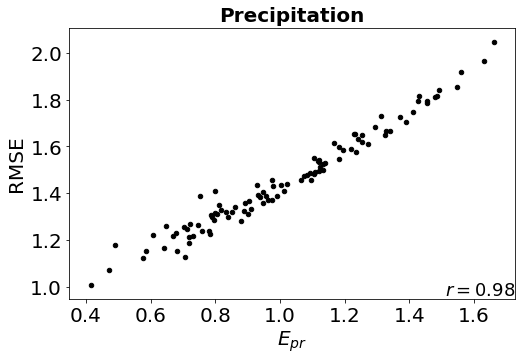

In [31]:
plt.figure(figsize=(8, 5))
    

ax = plt.gca()
#ax2 = ax.twinx()


df_fig.plot(kind='scatter', x='E_tas', y='RMSE', color = 'black', alpha=1, ax=ax)

#ax.axhline(0, color='k', alpha=0.5)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('$E_{pr}$', size = 20)
ax.set_ylabel('RMSE', size = 20)
ax.set_title('Precipitation', fontsize=20, 
             fontweight = 'bold')

plt.text(1,0.0,r'$r = 0.98$',horizontalalignment='right',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)

#plt.xlim([0, 4])
#plt.ylim([0, 4])

# Legend .................

#legend = [ 'Correlation', 'Unresolved fraction']
#ax.get_legend().remove()
#ax.legend(legend, fontsize=25, bbox_to_anchor=(1.65, 0.83)) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Correl_RMSE_E_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Multi-Linear Regression predictions

In [32]:
pc1_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof1_'+variable+'.npy')
pc2_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof2_'+variable+'.npy')
pc3_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof3_'+variable+'.npy')
pc4_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof4_'+variable+'.npy')
pc5_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof5_'+variable+'.npy')

PC_df = pd.DataFrame(pc1_pred)
PC_df['pc1'] = pc1_pred
PC_df['pc2'] = pc2_pred
PC_df['pc3'] = pc3_pred
PC_df['pc4'] = pc4_pred
PC_df['pc5'] = pc5_pred
PC_df = PC_df.drop(labels = 0, axis=1)
#PC_df

pc1_pred = PC_df['pc1'].to_xarray().rename({'index':'mode'})
pc2_pred = PC_df['pc2'].to_xarray().rename({'index':'mode'})
pc3_pred = PC_df['pc3'].to_xarray().rename({'index':'mode'})
pc4_pred = PC_df['pc4'].to_xarray().rename({'index':'mode'})
pc5_pred = PC_df['pc5'].to_xarray().rename({'index':'mode'})

In [33]:
pc1_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof1_'+variable+'.npy')
pc2_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof2_'+variable+'.npy')
pc3_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof3_'+variable+'.npy')
pc4_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof4_'+variable+'.npy')
pc5_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof5_'+variable+'.npy')

PC_val_df = pd.DataFrame(pc1_val)
PC_val_df['pc1'] = pc1_val
PC_val_df['pc2'] = pc2_val
PC_val_df['pc3'] = pc3_val
PC_val_df['pc4'] = pc4_val
PC_val_df['pc5'] = pc5_val
PC_val_df = PC_val_df.drop(labels = 0, axis=1)
#PC_df

pc1_val = PC_val_df['pc1'].to_xarray().rename({'index':'mode'})
pc2_val = PC_val_df['pc2'].to_xarray().rename({'index':'mode'})
pc3_val = PC_val_df['pc3'].to_xarray().rename({'index':'mode'})
pc4_val = PC_val_df['pc4'].to_xarray().rename({'index':'mode'})
pc5_val = PC_val_df['pc5'].to_xarray().rename({'index':'mode'})

In [34]:
E_multilinreg_val = RMSE_emulator(pc1_val, pc2_val, pc3_val, pc4_val, pc5_val, variable)
E_multilinreg_val

array([1.15906276, 1.12665839, 1.05108037, 1.29242529, 0.91002695,
       0.76438326, 1.35182628, 0.76567382, 0.76321392, 1.05235752,
       0.93229516, 1.38032999, 1.22820423, 1.15197792, 1.03059021,
       1.04282887, 0.7335293 , 0.63031205, 0.89770545, 0.67140023,
       0.97542587, 1.14042243, 1.07564512, 0.48003223, 0.68120586,
       0.82358167, 0.85140985, 0.70507956, 1.37997312, 1.46876898,
       0.63258313, 1.20057449, 0.65884325, 0.82372432, 0.60013496,
       1.35658508, 1.15485915, 0.7420217 , 0.76727342, 0.77522539,
       0.89729539, 1.24370964, 1.30273916, 0.86088469, 1.06810145,
       0.96255701, 1.16040998, 1.11749529, 1.54817258, 1.36107861,
       0.8941518 , 0.61646687, 1.36009556, 1.42310176, 1.2471473 ,
       0.68537915, 1.02823987, 1.40230755, 0.93448514, 0.76201104,
       0.74730059, 0.89855155, 1.39485823, 0.79528947, 1.12309973,
       1.04650504, 0.83461866, 0.74110707, 0.83003683, 0.92958535,
       0.81918981, 0.84169512, 1.10771388, 0.53715653, 0.89367

In [35]:
E_multilinreg_pred = RMSE_emulator(pc1_pred, pc2_pred, pc3_pred, pc4_pred, pc5_pred, variable)
E_multilinreg_pred

array([0.93448261, 0.87393549, 1.00677462, ..., 0.83247999, 0.65960595,
       0.92053598])

### Get the feedbacks

In [36]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
Fdbck_multilinreg_val = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_FdbckN.npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")

Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

In [37]:
E_PPE_df = pd.DataFrame(E_PPE, columns=['E_PPE'])
E_PPE_df['Fdbck'] = Fdbck_PPE

In [38]:
E_multilinreg_val_df = pd.DataFrame(E_multilinreg_val, columns=['E_multilinreg_val'])
E_multilinreg_val_df['Fdbck_val'] = Fdbck_multilinreg_val

E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred[0:100000], columns=['E_multilinreg_pred'])
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred
#E_multilinreg_pred_df

### Plotting

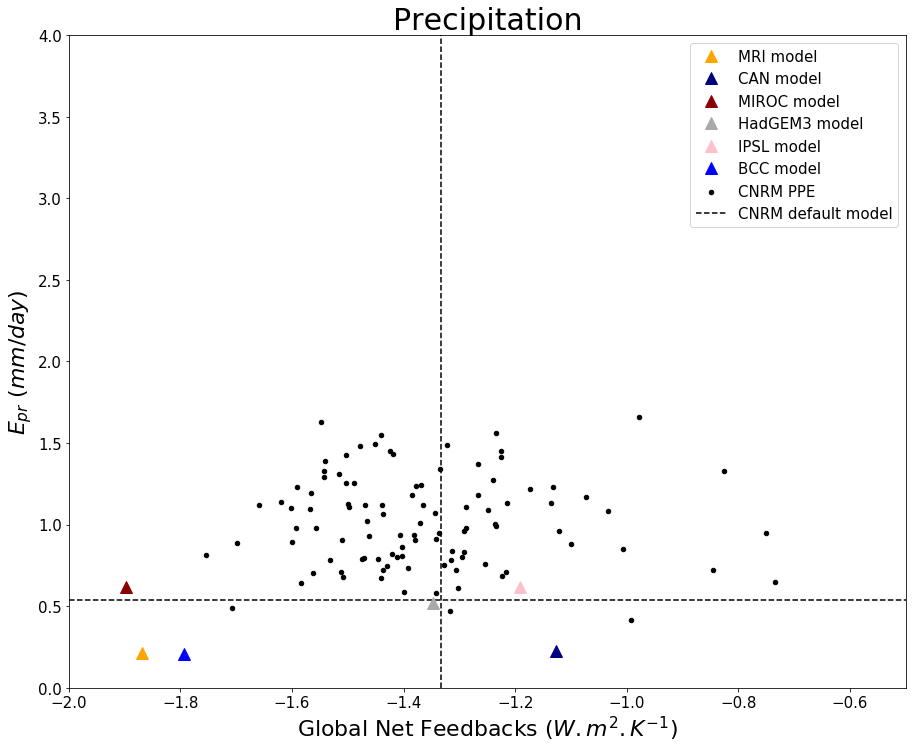

In [39]:
ax = plt.gca()

E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)


plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,4)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

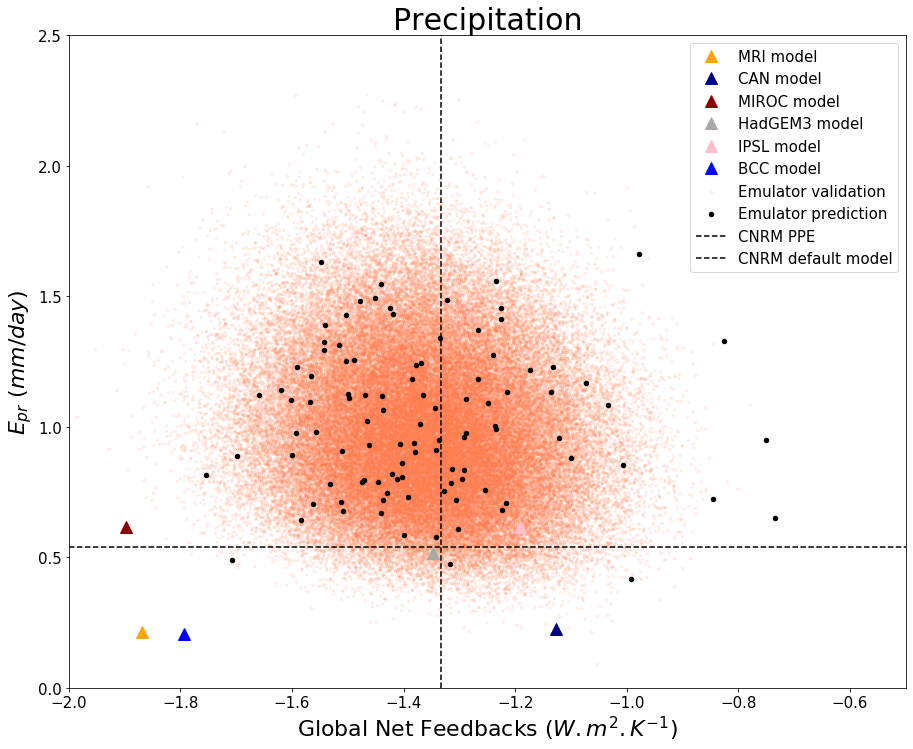

In [40]:
ax = plt.gca()

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#E_multilinreg_val_df.plot(kind='scatter', x='Fdbck_val', y='E_multilinreg_val', color='red', alpha=1, figsize=(15, 12), 
#                     marker='x', ax = ax)
E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='coral', alpha=0.1, figsize=(15, 12), marker='.', ax = ax)


E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'Emulator validation', 'Emulator prediction', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,2.5)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_pred.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [41]:
fluxes_biases = E_PPE_df
fluxes_biases['E_multilinreg_val'] = E_multilinreg_val_df['E_multilinreg_val']
fluxes_biases['OSE_multilinreg'] = abs(fluxes_biases['E_PPE'] - fluxes_biases['E_multilinreg_val'])
fluxes_biases

,E_PPE,Fdbck,E_multilinreg_val,OSE_multilinreg
0,1.327665,-0.825236,1.159063,0.168602
1,1.119965,-1.659636,1.126658,0.006693
2,1.131642,-1.215000,1.051080,0.080561
3,1.485628,-1.321641,1.292425,0.193202
4,0.947449,-0.750397,0.910027,0.037422
...,...,...,...,...
97,1.312706,-1.516367,1.197248,0.115458
98,0.641261,-1.584491,0.795043,0.153783
99,0.787310,-1.474525,0.729139,0.058171
100,0.788963,-1.445422,0.678736,0.110227


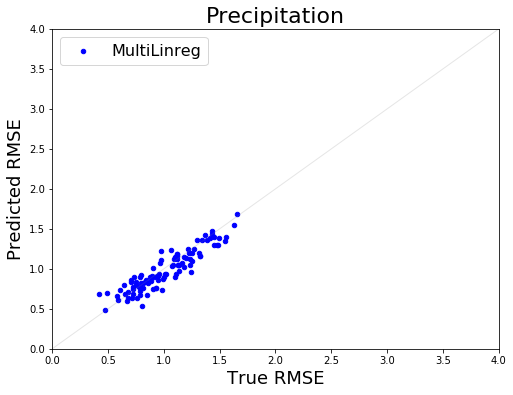

In [42]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title= TITLE 
fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
#fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_lasso_val', color='blue', alpha=0.6, 
#                     marker="o", ax = ax)

plt.xlabel('True RMSE', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted RMSE', fontsize = 18)#, fontsize=18)
plt.legend(['MultiLinreg', 'LASSO'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0,4)
plt.xlim(0,4)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### Save data 

In [43]:
OSE = fluxes_biases['OSE_multilinreg'].mean()
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+variable+'.npy', OSE)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy', E_p1)

In [44]:
RMSE_val = fluxes_biases['E_multilinreg_val']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_val_'+variable+'.npy', RMSE_val)

In [45]:
## SAVE 
E_multilinreg_pred = E_multilinreg_pred_df['E_multilinreg_pred'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy', E_multilinreg_pred)

E_PPE = E_PPE_df['E_PPE'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy', E_PPE)

### [Back to the top](#top)

# <a id="histograms">Figure histograms</a> </li>

In [46]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedback = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

In [47]:
E_MLR = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy')
Fdbck_MLR = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
MLR_df=pd.DataFrame(E_MLR, columns=['E_MLR'])
MLR_df['Fdbck'] = Fdbck_MLR
#MLR_df

In [48]:
E_MLR_short = []
tmp = []
Fdbck_MLR_short = []
cpt=0

for i in MLR_df['E_MLR']:
    if i <= E_p1:
        E_MLR_short.append(i)
        toto = MLR_df['Fdbck'][cpt]
        Fdbck_MLR_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

MLR_short = pd.DataFrame()
MLR_short['Fdbck'] = Fdbck_MLR_short
MLR_short['E_MLR'] = E_MLR_short
MLR_short

,Fdbck,E_MLR
0,-1.216964,0.361218
1,-1.296605,0.437800
2,-1.166431,0.518526
3,-1.426252,0.405734
4,-1.110015,0.480431
...,...,...
3586,-1.146426,0.534287
3587,-1.364198,0.526562
3588,-1.129836,0.538435
3589,-1.427530,0.533679


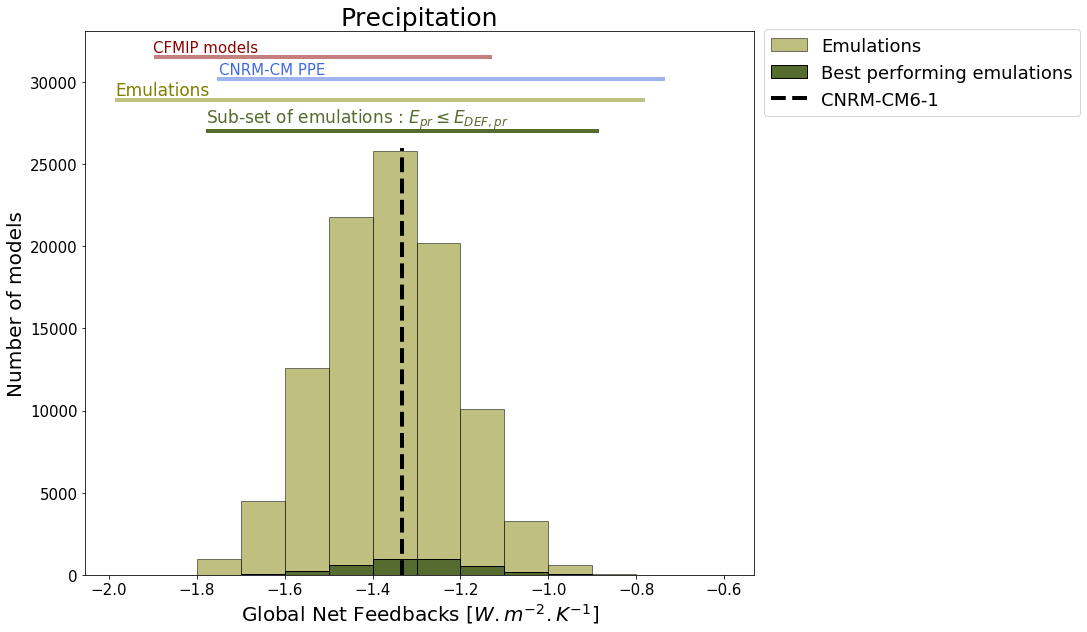

In [49]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_MLR, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'olive', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(MLR_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'darkolivegreen', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 26000,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(31500.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 31800.0, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(30200.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 30500.0, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(27000.0,xmin = MLR_short['Fdbck'].min(),xmax = MLR_short['Fdbck'].max(),
           colors='darkolivegreen', linewidth=4.0, linestyles='solid')
plt.text(MLR_short['Fdbck'].min(), 27500.0, 'Sub-set of emulations : $E_{pr}\leq E_{DEF,pr}$', 
         color = 'darkolivegreen', fontsize=17)

legend=['Emulations', 'Best performing emulations', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [50]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
#PPE_df

In [51]:
E_PPE_short = []
tmp = []
Fdbck_PPE_short = []
cpt=0

for i in PPE_df['E_PPE']:
    if i <= E_p1:
        E_PPE_short.append(i)
        toto = PPE_df['Fdbck'][cpt]
        Fdbck_PPE_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

PPE_short = pd.DataFrame()
PPE_short['Fdbck'] = Fdbck_PPE_short
PPE_short['E_PPE'] = E_PPE_short
#PPE_short

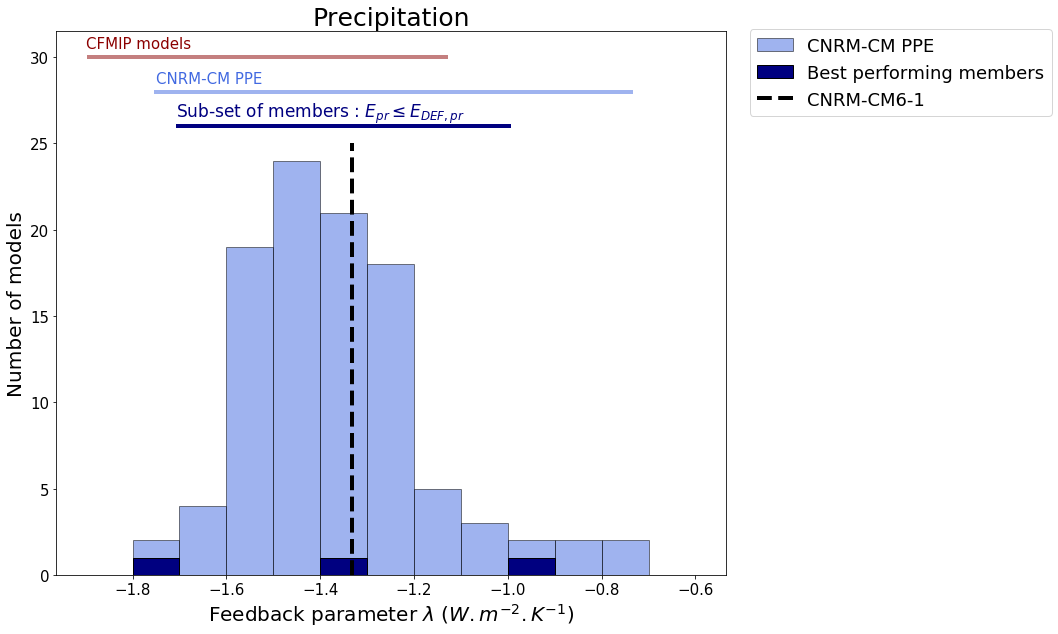

In [52]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_PPE, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'royalblue', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(PPE_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'navy', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 25,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(30.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 30.5, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(28.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 28.5, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

#plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
#           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
#plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(26.0,xmin = PPE_short['Fdbck'].min(),xmax = PPE_short['Fdbck'].max(),
           colors='navy', linewidth=4.0, linestyles='solid')
plt.text(PPE_short['Fdbck'].min(), 26.5, 'Sub-set of members : $E_{pr}\leq E_{DEF,pr}$', 
         color = 'navy', fontsize=17)

legend=['CNRM-CM PPE', 'Best performing members', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="optim">Step 5 - Optimisation</a> </li>

The objective here is to optimize the emulators described above in order to obtain a sub-set of the best parametrizations for each bins of feedback values. In other words, we aim to fine the parametrization which minimizes the error $E_{tot}$ given by the control mean state emulator, while showing a global net feedback value predicted by the feedback emulator within a chosen bin. It is a case of linear minimization with constraint and the optimizer used here comes from the SciPy Python's library and uses sequential least squares programming (SLSQP).

### Functions 

In [56]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/N_error)
    return E

In [57]:
# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

# FONCTIONS FEEDBACKS

def em_fdb_std(x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

In [58]:
# FONCTION JACOBIAN

def jacobian(x, variable) :
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    Beta1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1.npy')
    Beta2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2.npy')
    Beta3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3.npy')
    Beta4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4.npy')
    Beta5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5.npy')
    
    R1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1.npy')
    R2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2.npy')
    R3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3.npy')
    R4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4.npy')
    R5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5.npy')
    
    C1 = R1 - U_obs[0]
    C2 = R2 - U_obs[1]
    C3 = R3 - U_obs[2]
    C4 = R4 - U_obs[3]
    C5 = R5 - U_obs[4]
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    A = x_std*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + (Beta1*C1 + Beta2*C2 + Beta3*C3 + 
                                                                    Beta4*C4 + Beta5*C5)
    
    tmp = x_std**2*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + 2*x_std*(Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5) +(C1**2+C2**2+C3**2+C4**2+C5**2)
    B = sqrt(tmp)
    
    D = 1/sqrt(N_error)
    
    jac = (A/B)*D
    
    return jac


# FONCTIONS CONTRAINTES

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


# FONCTIONS OPTIMISATION

def Optimization(x_best, ind, xlim, variable) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_emulator(x0, variable)
        #print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
        sol = minimize(function_RMSE_emulator,  x0, args=(variable), method='SLSQP', bounds=xlim, constraints=(cons1, cons2), 
                   jac = jacobian, options={'disp': True}, tol = 0.001)    
                        # , 'maxiter' : 250   jac = jacobian,
    

        tmp_fun = function_RMSE_emulator(sol.x, variable)
        tmp_fdbck = em_fdb(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [59]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

### Get the data

In [60]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

In [61]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')

E_PPE_df = pd.DataFrame()
E_PPE_df['Fdbck'] = Fdbck_PPE
E_PPE_df['RMSE'] = E_PPE
E_PPE_df

,Fdbck,RMSE
0,-0.825236,1.327665
1,-1.659636,1.119965
2,-1.215000,1.131642
3,-1.321641,1.485628
4,-0.750397,0.947449
...,...,...
97,-1.516367,1.312706
98,-1.584491,0.641261
99,-1.474525,0.787310
100,-1.445422,0.788963


In [62]:
E_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_"+variable+".npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")


E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred)
E_multilinreg_pred_df['E_multilinreg_pred'] = E_multilinreg_pred
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred[0:100000]
E_multilinreg_pred_df = E_multilinreg_pred_df.drop([0], axis=1)
E_multilinreg_pred_df

,E_multilinreg_pred,Fdbck_pred
0,0.934483,-1.499698
1,0.873935,-1.339351
2,1.006775,-1.323732
3,1.171886,-1.541909
4,1.015541,-1.346961
...,...,...
99995,0.880405,-1.453679
99996,1.137027,-1.410350
99997,0.832480,-1.296397
99998,0.659606,-1.299809


### Initial guess for Optimization 1

In [63]:
E_multilinreg_pred_df['Fdbck_pred_round'] = E_multilinreg_pred_df['Fdbck_pred'].round(decimals=2)
E_multilinreg_pred_df = E_multilinreg_pred_df.set_index('Fdbck_pred_round')
E_multilinreg_pred_df['members'] = range(0,100000,1) 
#E_multilinreg_pred_df        

In [64]:
new_df=pd.DataFrame()
new_df['E_multilinreg_pred_best'] = E_multilinreg_pred_df['E_multilinreg_pred'].groupby('Fdbck_pred_round').min()
new_df = new_df.reset_index()
#new_df

In [65]:
list_RMSE = new_df['E_multilinreg_pred_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_pred_df['E_multilinreg_pred'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_pred_df['Fdbck_pred'].iloc[cpt])
            tmp_member.append(E_multilinreg_pred_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck_pred'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
#new_df

### Optimization 1 

In [66]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [67]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
#xlim

In [68]:
sol_df = Optimization(x_best, 0.0001, xlim, variable)
#sol_df

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7123669045877483
            Iterations: 3
            Function evaluations: 14
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6778690682562781
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6256869296951787
            Iterations: 4
            Function evaluations: 18
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7172115700707247
            Iterations: 5
            Function evaluations: 18
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6502607926892615
            Iterations: 4
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.38252733634228486
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.29962361585234043
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.35702309319859465
            Iterations: 3
            Function evaluations: 16
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3204957561579644
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3128541916605632
            Iterations: 3
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2830818148541622
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.19349783474720156
            Iterations: 4
            Function evaluations: 19
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.25200433732279304
            Iterations: 3
            Function evaluations: 17
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.28234956819233564
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.1525712569327844
            Iterations: 3
            Function eval

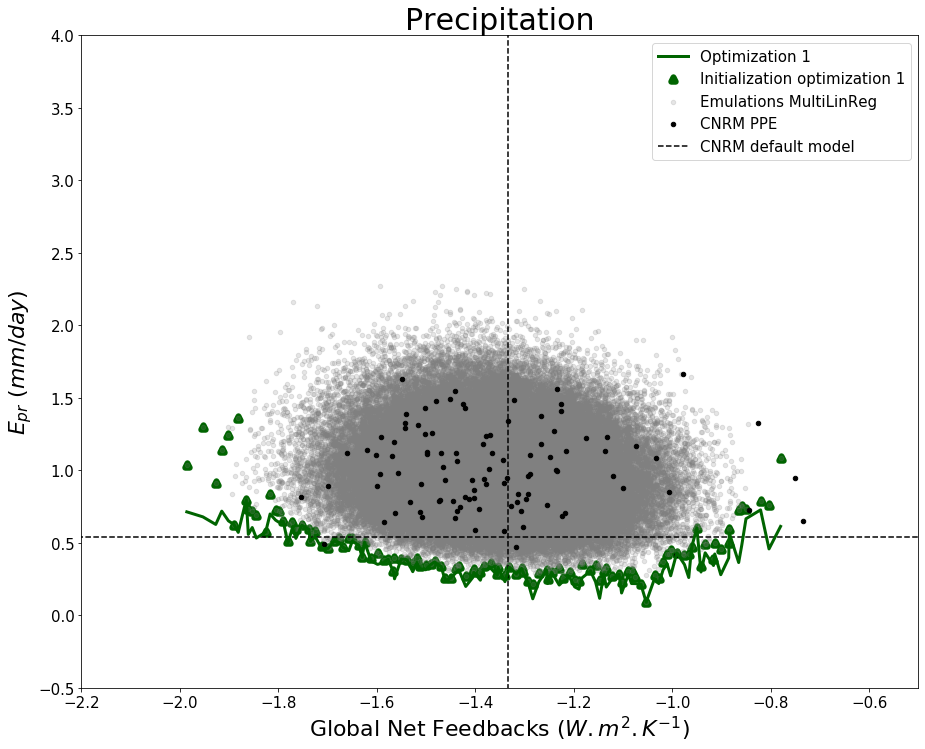

In [69]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Initial guess for Optimization 2 (param. moothing)

In [70]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.985856,0.060000,0.500000,1.796562,29.794826,-0.010000,8.486434,3.061528,0.00050,0.001000,...,-2.425198,-25.291247,0.044223,13.711528,0.000010,0.979862,0.500000,0.538710,0.500000,5.881918
1,-1.953241,0.060000,0.500000,1.344590,23.603613,-0.010000,7.417690,4.058174,0.00050,0.001000,...,-2.487838,-26.092028,0.044768,13.504444,0.000011,0.972947,0.514611,0.554071,0.504147,5.629677
2,-1.927100,0.060000,0.500000,0.997423,22.826722,-0.049153,7.611945,2.460744,0.00050,0.001000,...,-2.549005,-26.884330,0.045316,13.295487,0.000013,0.966060,0.529075,0.569298,0.508303,5.381218
3,-1.914873,0.060000,0.500000,1.008666,21.053899,-0.111136,8.243370,0.849945,0.00050,0.001000,...,-2.607279,-27.660166,0.045872,13.082957,0.000014,0.959225,0.543251,0.584257,0.512479,5.140121
4,-1.901309,0.068134,0.513931,1.227146,18.858615,-0.135997,7.538059,0.508688,0.00061,0.000774,...,-2.661338,-28.412487,0.046440,12.865488,0.000016,0.952467,0.557009,0.598825,0.516685,4.909593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.858678,0.088986,2.310327,0.761391,19.312799,-0.378118,1.972264,6.056084,0.01000,0.000050,...,-2.621253,-45.095621,0.012046,7.618525,0.000092,0.604285,0.553771,0.916947,0.865692,6.202971
109,-0.850113,0.077395,2.413181,0.840859,14.458904,-0.371446,1.531688,5.330152,0.01000,0.000050,...,-2.591618,-45.628741,0.011530,8.033719,0.000094,0.589193,0.543073,0.932903,0.868028,6.574930
110,-0.820549,0.080313,2.460272,0.930642,16.752004,-0.348440,0.557953,4.698709,0.01000,0.000050,...,-2.560423,-46.194201,0.011017,8.468793,0.000096,0.573609,0.532165,0.949525,0.870606,6.960366
111,-0.803375,0.103908,2.448883,1.198661,22.389092,-0.295117,0.646296,4.687491,0.01000,0.000050,...,-2.528190,-46.782046,0.010508,8.917378,0.000098,0.557688,0.521114,0.966606,0.873348,7.355083


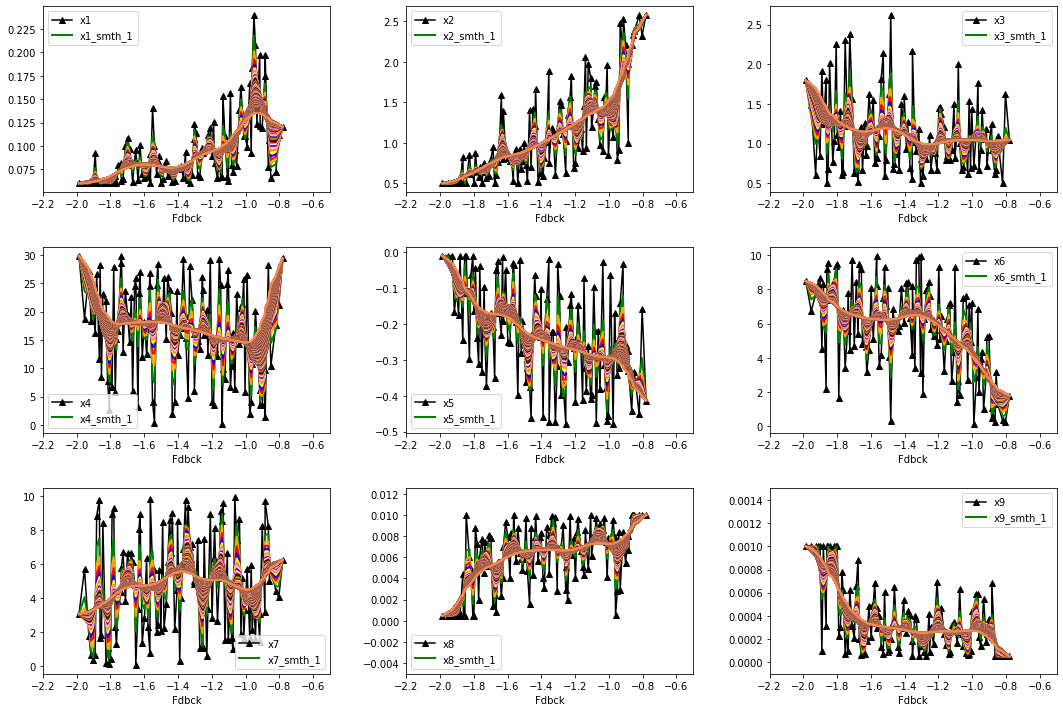

In [71]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Optimization 2

In [72]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.06      , 0.5       , 1.79656163, ..., 0.53870991, 0.5       ,
        5.88191767],
       [0.0604233 , 0.51008197, 1.74572958, ..., 0.55407128, 0.50414687,
        5.62967748],
       [0.06085018, 0.52014136, 1.69557433, ..., 0.56929764, 0.50830336,
        5.38121753],
       ...,
       [0.12437007, 2.42668157, 1.04145683, ..., 0.94952481, 0.87060573,
        6.96036617],
       [0.12237485, 2.5025392 , 1.04437119, ..., 0.9666061 , 0.87334844,
        7.35508271],
       [0.12034615, 2.57871783, 1.04743793, ..., 0.98392159, 0.8761752 ,
        7.75453096]])

In [73]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_emulator(i, variable)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.985856,0.712367
1,-1.953241,0.697585
2,-1.927100,0.683149
3,-1.914873,0.669146
4,-1.901309,0.655644
...,...,...
108,-0.858678,0.484356
109,-0.850113,0.513684
110,-0.820549,0.544992
111,-0.803375,0.577927


In [74]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variable)
#sol_df_2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.708251909605018
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6964324615825969
            Iterations: 2
            Function evaluations: 15
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6831418689680114
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6691452224681467
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6556448934464261
            Iterations: 1
            Function evaluati

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.31405613313034536
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.30814112294595547
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.30258784734780075
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2973814489063244
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.29250376968077696
            Iterations: 1
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.18821831912220846
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.18900452211004898
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.19051210656143724
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.19277544927977197
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.19581550143936746
            Iterations: 1
            Function ev

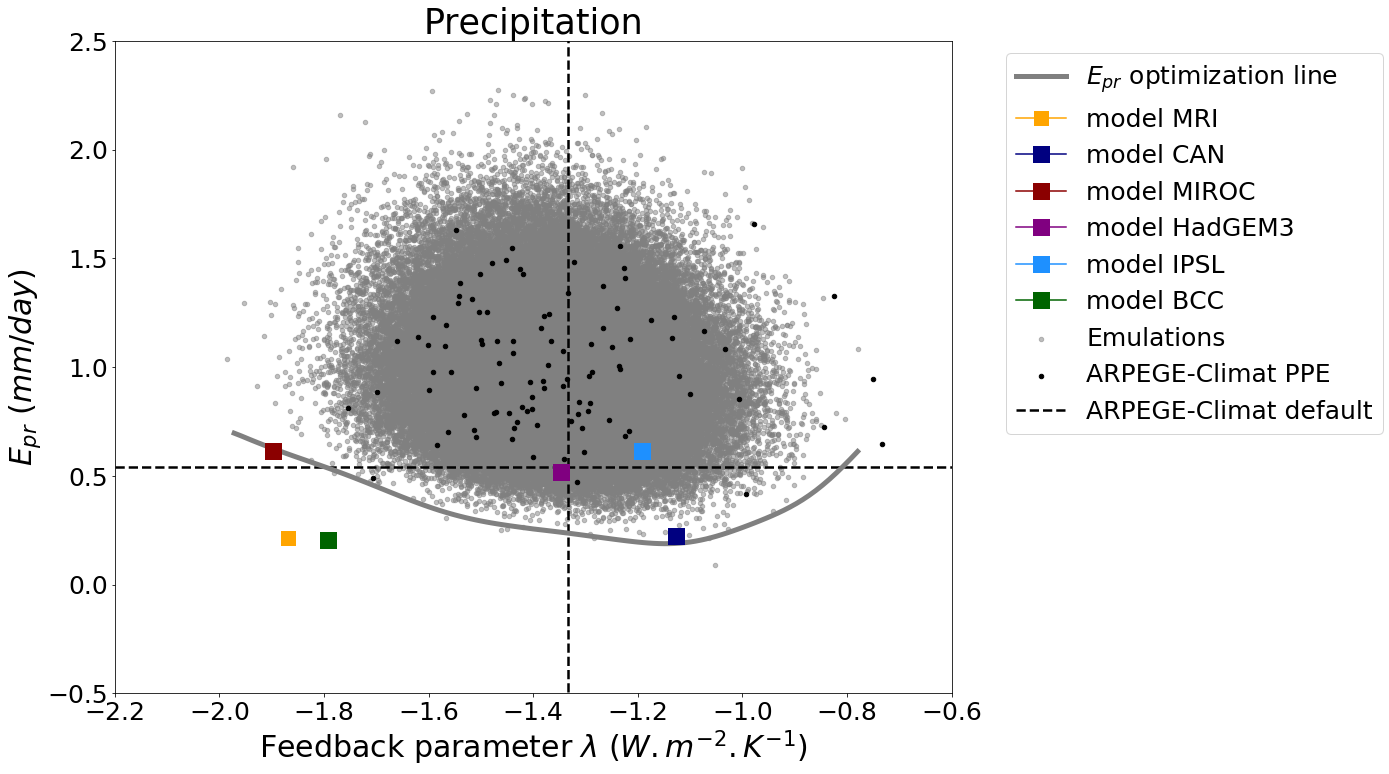

In [76]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.5, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), alpha=1.0,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = [ '$E_{pr}$ optimization line', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','ARPEGE-Climat PPE', 'ARPEGE-Climat default']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=25, bbox_to_anchor=(1.05, 1))

plt.title(TITLE, fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(-0.5,2.5)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save data

In [77]:
RMSE_optim2 = sol_df_2['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

## Projection of sub-set on EOF basis

### Settings 

In [17]:
ENSEMBLE = 'ENSEMBLE4_selection/'
path_PPE_short = '/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
product = 'GPCP'

In [180]:
nb_p_select = ['p840', 'p841', 'p842', 'p843','p844', 'p845', 'p846', 'p847']
len(nb_p_select)

8

In [117]:
N_error=128*256

### Functions

In [102]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/N_error)
    return E

In [21]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred


# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

### EOF, tas_mean and PCs

In [22]:
Mean =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
#Mean

In [23]:
pc1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)
#PC_df

PC_df

,pc1,pc2,pc3,pc4,pc5
0,-39.641038,-67.600960,26.745839,20.957515,-22.195813
1,-59.308941,17.939061,20.367842,9.104649,3.244862
2,-22.841644,8.606309,23.933690,21.381769,-46.843043
3,-127.004260,-9.039118,29.304957,2.975930,6.573410
4,73.567028,-0.094295,72.451824,-48.501994,-56.641998
...,...,...,...,...,...
97,-97.054192,21.515287,2.509981,-1.262494,-15.473365
98,59.813746,55.515797,-29.819833,24.966084,2.176767
99,23.685482,10.585372,1.242809,17.821676,6.404811
100,32.340656,13.058195,47.639314,10.395303,5.531966


### Get the subset data

In [24]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

## Error estimate in ARPEGE-Climat

In [163]:
E_df_selection=[]
for i in nb_p_select :
    U = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/U_'+i+'_'+variable+'.npy')
    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    E_df_selection.append(E)

E_df_selection

[0.7421351713992123,
 0.7771727717860076,
 0.7629240334698723,
 0.770651080381192,
 0.8601155702859234,
 0.8455785590339456,
 0.853169685828777,
 0.9014285471702687]

In [147]:
Fdbck_selection = np.load('/data/home/globc/peatier/CNRMppe/PPE/'+ENSEMBLE+'files/npy/QUAT_Net_feedbacks.npy')
Fdbck_selection

array([-1.69343424, -1.7067678 , -1.61947143, -1.50831775, -1.41209233,
       -1.13269941, -0.87172544, -0.56140771])

## Error estimate with emulator

In [105]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select.npy')
df_select = pd.DataFrame(file).drop([8])
df_select

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.776953,-1.985756,0.060000,0.782793,2.142053,29.775351,-0.010000,8.664463,3.020343,0.000500,...,-2.471254,-25.266850,0.045748,13.661456,0.000010,0.913490,0.620287,0.500000,0.500000,6.042944
1,1.261023,-1.793487,0.092451,0.775988,1.835889,16.677694,-0.095253,6.666214,4.508329,0.003164,...,-2.837226,-32.421030,0.057842,11.727646,0.000038,0.882939,0.742863,0.639256,0.586545,4.707199
2,0.974675,-1.639187,0.114980,0.869206,1.792741,16.898659,-0.112145,4.443179,4.174728,0.005127,...,-2.700198,-33.902888,0.059850,8.234620,0.000054,0.863454,0.761513,0.711625,0.627510,4.275389
3,0.814275,-1.489048,0.136523,1.109424,1.903055,17.453172,-0.100000,3.078862,3.825227,0.005717,...,-2.430384,-32.707234,0.055823,4.995179,0.000059,0.828581,0.718952,0.752331,0.673440,4.086714
4,0.720396,-1.338640,0.150080,1.262510,1.727699,16.548401,-0.131147,2.672060,4.260765,0.004969,...,-2.419481,-33.721094,0.035107,3.799664,0.000061,0.842050,0.684948,0.758052,0.700458,4.511644
5,0.694808,-1.188343,0.160636,1.537920,1.523233,12.986488,-0.175298,2.495307,4.327776,0.005232,...,-2.658346,-35.855889,0.025262,3.291661,0.000064,0.782844,0.697536,0.731226,0.732272,4.363352
6,0.718234,-1.038806,0.163307,1.828007,1.512815,13.946728,-0.216507,2.336977,3.425777,0.005186,...,-2.648154,-38.136234,0.019986,2.696607,0.000062,0.678240,0.709589,0.734188,0.753012,4.404452
7,1.221805,-0.873181,0.165083,2.219252,1.360215,19.891069,-0.339322,1.793060,4.713772,0.005150,...,-2.599949,-43.551279,0.015234,5.622651,0.000069,0.616350,0.623375,0.821796,0.793923,5.837056


In [106]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_total.npy')
df_optim_total = pd.DataFrame(file)
df_optim_total

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.776953,-1.985756,0.060000,0.782793,2.142053,29.775351,-0.010000,8.664463,3.020343,0.000500,...,-2.471254,-25.266850,0.045748,13.661456,0.000010,0.913490,0.620287,0.500000,0.500000,6.042944
1,1.762960,-1.971606,0.060000,0.771711,2.109585,28.387070,-0.010000,8.517878,3.179734,0.000500,...,-2.506757,-25.984719,0.042037,13.524081,0.000010,0.909729,0.629001,0.500000,0.500000,5.884610
2,1.747476,-1.957607,0.064617,0.828770,2.153730,27.047637,-0.044442,8.500317,3.359057,0.000905,...,-2.561124,-26.715433,0.043889,13.598473,0.000015,0.903923,0.654323,0.520200,0.512286,5.773078
3,1.701060,-1.943609,0.066933,0.817078,2.120559,25.715006,-0.049635,8.352687,3.511770,0.001104,...,-2.595572,-27.401009,0.045458,13.461733,0.000017,0.899978,0.663194,0.530337,0.518452,5.622744
4,1.655735,-1.929758,0.069233,0.806180,2.088401,24.436898,-0.054642,8.205983,3.657854,0.001300,...,-2.628760,-28.054637,0.046972,13.325501,0.000020,0.896328,0.671872,0.540407,0.524583,5.480335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,1.455842,-0.834215,0.157016,2.346720,1.264706,23.537382,-0.364038,1.787752,5.313115,0.005856,...,-2.563512,-45.052371,0.014225,7.069913,0.000073,0.596186,0.587515,0.871901,0.797610,6.606023
109,1.448764,-0.820870,0.119989,2.328477,1.221399,24.918576,-0.359082,1.792622,5.529209,0.007510,...,-2.542609,-45.587788,0.012499,7.554453,0.000084,0.600643,0.569731,0.880656,0.760203,6.873109
110,1.618494,-0.807407,0.060000,2.270250,1.173089,26.355960,-0.346376,1.799802,5.749377,0.010000,...,-2.517253,-46.132130,0.010000,8.023230,0.000100,0.612746,0.548887,0.883723,0.698772,7.139820
111,1.701626,-0.793798,0.060000,2.325438,1.140221,27.850900,-0.357062,1.806978,5.987342,0.010000,...,-2.501056,-46.721158,0.010000,8.589710,0.000100,0.602930,0.536530,0.904800,0.706588,7.436392


In [107]:
E_emulator_selection = []
for i in range(0,len(df_select),1) :
    x = df_select.iloc[i][2:]
    E = function_RMSE_emulator(x, variable)
    E_emulator_selection.append(E)

E_emulator_selection

[0.8133239122031618,
 0.6885646319419845,
 0.5802441416902719,
 0.5456185039002241,
 0.5146702265624653,
 0.5425261622130786,
 0.5776147635965772,
 0.6018804710815068]

In [108]:
E_optim_total = []
for i in range(0,len(df_optim_total),1) :
    x = df_optim_total.iloc[i][2:]
    E = function_RMSE_emulator(x, variable)
    E_optim_total.append(E)
    
E_optim_total

[0.8133239122031618,
 0.7963626815907573,
 0.8215396555010512,
 0.8091592511628153,
 0.7971214380117152,
 0.7855423666671216,
 0.7744314928343865,
 0.7637713428817662,
 0.75352407075948,
 0.7436368598995848,
 0.734048001163788,
 0.7246932786252002,
 0.7155121271128179,
 0.7064530541727101,
 0.697477903758766,
 0.6885646319419845,
 0.6797084202486253,
 0.6709211221932443,
 0.6622292203455047,
 0.6536706369628859,
 0.6452908566558173,
 0.6371388637374571,
 0.6292633615367219,
 0.6217096351026391,
 0.6145172673031946,
 0.6077187542843083,
 0.6013389225598672,
 0.5953949509896019,
 0.5898967574184341,
 0.5848475187855167,
 0.5802441416902719,
 0.5760775704272014,
 0.5723328947039233,
 0.5689892882442551,
 0.566019865403934,
 0.5633915824946423,
 0.5610653312223299,
 0.5589963703779216,
 0.5571352154716153,
 0.5554290529827874,
 0.5538236697349525,
 0.5522657983109746,
 0.5507056920795386,
 0.5490996769717089,
 0.5474123986657872,
 0.5456185039002241,
 0.5437035638888639,
 0.541664155878387

In [109]:
df_optim_total_final= pd.DataFrame(E_optim_total, columns=['RMSE'])
df_optim_total_final['Fdbck']= df_optim_total[1]
df_optim_total_final

,RMSE,Fdbck
0,0.813324,-1.985756
1,0.796363,-1.971606
2,0.821540,-1.957607
3,0.809159,-1.943609
4,0.797121,-1.929758
...,...,...
108,0.623478,-0.834215
109,0.721413,-0.820870
110,0.997837,-0.807407
111,0.981925,-0.793798


In [110]:
RMSE_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy')
Fdbck_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

,0,sol_fun,Fdbck
0,0.708252,0.708252,-1.985756
1,0.696432,0.696432,-1.971673
2,0.683142,0.683142,-1.957604
3,0.669145,0.669145,-1.943611
4,0.655645,0.655645,-1.929769
...,...,...,...
108,0.484356,0.484356,-0.833763
109,0.513684,0.513684,-0.820448
110,0.544992,0.544992,-0.807005
111,0.577927,0.577927,-0.793475


In [111]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
PPE_df

,E_PPE,Fdbck
0,1.327665,-0.825236
1,1.119965,-1.659636
2,1.131642,-1.215000
3,1.485628,-1.321641
4,0.947449,-0.750397
...,...,...
97,1.312706,-1.516367
98,0.641261,-1.584491
99,0.787310,-1.474525
100,0.788963,-1.445422


## Plot

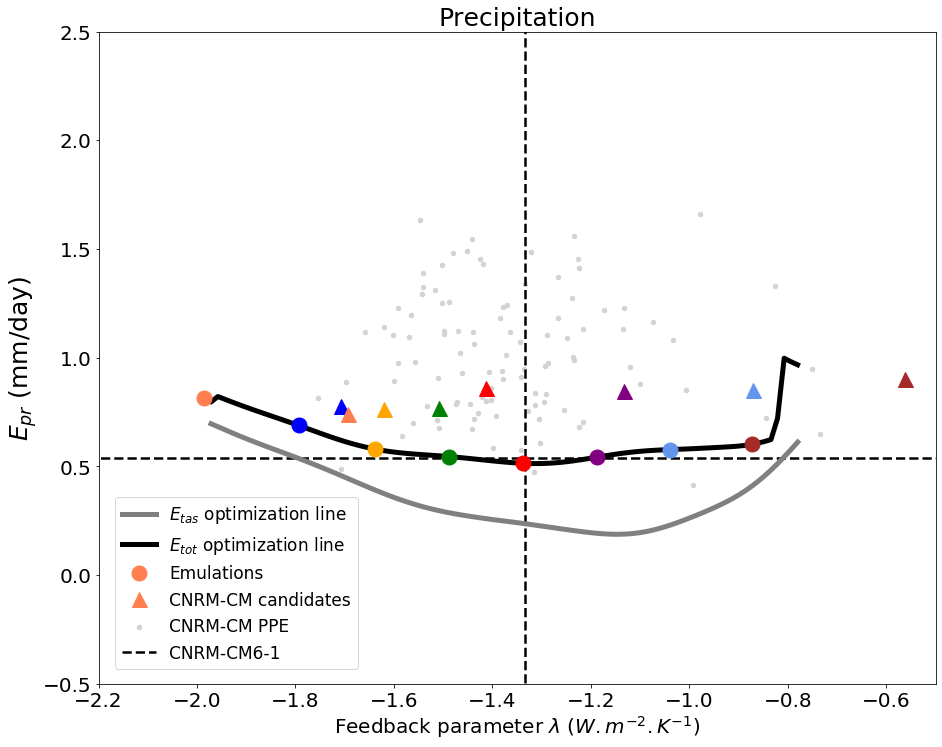

In [112]:
colors = ['coral','blue','orange','green','red','purple','cornflowerblue', 'brown']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, figsize=(15, 12), ax = ax)

df_optim_total_final.plot(kind='line', x='Fdbck', y='RMSE', color='black', alpha=1, linewidth=5, ax=ax)

#E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
#                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='lightgray', 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5, zorder=1)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


for i in colors :
    if cpt == 0 :
        plt.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], color=i, marker='o', linewidth=0, markersize=15, zorder=8)

        plt.plot(Fdbck_selection[cpt], E_df_selection[cpt], color=i, marker='^', linewidth=0, markersize=15, zorder=9)
        cpt+=1
    else :
        plt.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], color=i, marker='o', linewidth=0, markersize=15, label='_nolegend_')

        plt.plot(Fdbck_selection[cpt], E_df_selection[cpt], color=i, marker='^', linewidth=0, markersize=15, label='_nolegend_')
        cpt+=1

legend = [ '$E_{tas}$ optimization line','$E_{tot}$ optimization line', 'Emulations',
          'CNRM-CM candidates', 'CNRM-CM PPE', 'CNRM-CM6-1']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=20)
plt.ylabel(ylabel, fontsize=25)
plt.legend(legend, fontsize=17, bbox_to_anchor=(0.32, 0.30))

plt.title(TITLE, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(-0.5,2.5)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_selection.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [113]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/E_selection_'+variable+'.npy', E_df_selection)

### [Back to the top](#top)

# <a id="correl">Check correlation with simple RMSE</a> </li> 

## Get the data 

In [165]:
# PPE amip simulations 
filename='*_amip_*.nc'


amip={}

for nb_p in nb_p_list :
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_pr_xarr(path, filename, variables)
    

In [179]:
filename='*_amip_*.nc'
amip_select={}

for nb_p in nb_p_select :
    path=path_PPE+'ENSEMBLE4_selection/CNRM-CM6-1_amip_PPE_ENSEMBLE4_selection/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    tmp = get_3D_pr_xarr(path, filename, variables)
    amip_select[str(nb_p)] = tmp.assign_coords(lat=amip_list[0]['lat'])
    

In [167]:
path_observation = '/data/scratch/globc/peatier/obs_data/GPCP/'
filename = 'pr_mon_mean_197901-201912_regrid.nc'
variable_obs = 'pr'

def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month

    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

path = path_observation
variables = [variable_obs]
df_obs = load_monthly_clim(path, filename, variables)
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    pr       (lat, lon) float32 0.3159773 0.3089214 ... 0.50588834 0.50602216

In [168]:
# Reference p1
diff = (amip['p1'].values - obs[variable_obs].values)**2
diff_p1 = sqrt(sum(diff)/(128*256))
diff_p1

KeyError: 'p1'

In [169]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_list :
    mod = amip[p]*df_W
    observation = obs[variable_obs]*df_W
    diff_tmp = (mod - observation)**2
    diff = sqrt(diff_tmp['W'].sum(['lat', 'lon'])/(128*256))
    #print(diff_tmp)
    ej[p] = diff
    ej_list.append(float(diff))

In [170]:
df_fig = pd.DataFrame(E_PPE, columns=['E_tas'])
df_fig['RMSE'] = ej_list
df_fig

,E_tas,RMSE
0,1.327665,1.615625
1,1.119965,1.494008
2,1.131642,1.448093
3,1.485628,1.766993
4,0.947449,1.353116
...,...,...
97,1.312706,1.679986
98,0.641261,1.114605
99,0.787310,1.258110
100,0.788963,1.244036


In [171]:
r = np.corrcoef(df_fig['E_tas'], df_fig['RMSE'])
r

array([[1.        , 0.98302322],
       [0.98302322, 1.        ]])

In [181]:
ej = {}
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_select :
    mod = amip_select[p]*df_W
    observation = obs[variable_obs]*df_W
    diff_tmp = (mod - observation)**2
    diff = sqrt(diff_tmp['W'].sum(['lat', 'lon'])/(128*256))
    #print(diff_tmp)
    ej[p] = diff
    ej_list.append(float(diff))
    
df_fig_select = pd.DataFrame(E_df_selection, columns=['E_tas'])
df_fig_select['RMSE'] = ej_list
df_fig_select

,E_tas,RMSE
0,0.742135,1.337348
1,0.777173,1.271089
2,0.762924,1.220048
3,0.770651,1.198474
4,0.860116,1.258519
5,0.845579,1.229315
6,0.853170,1.239550
7,0.901429,1.300929


In [182]:
r = np.corrcoef(df_fig_select['E_tas'], df_select['RMSE'])
r

array([[1.        , 0.02639514],
       [0.02639514, 1.        ]])

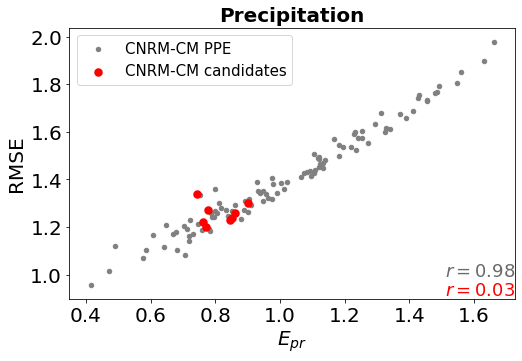

In [184]:
plt.figure(figsize=(8, 5))
    

ax = plt.gca()
#ax2 = ax.twinx()


df_fig.plot(kind='scatter', y='RMSE', x='E_tas', color = 'gray', alpha=1, ax=ax)
df_fig_select.plot(kind='scatter', y='RMSE', x='E_tas', color = 'red', linewidth=4, alpha=1, ax=ax)

#ax.axhline(0, color='k', alpha=0.5)
#ax.set_ylim(0, 1.1)
ax.set_xlabel('$E_{pr}$', size = 20)
ax.set_ylabel('RMSE', size = 20)
ax.set_title('Precipitation', fontsize=20, 
             fontweight = 'bold')

plt.text(1,0.07,r'$r = 0.98$',horizontalalignment='right',color='dimgray',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)
plt.text(1,0.0,r'$r = 0.03$',horizontalalignment='right', color='red',
     verticalalignment='bottom', transform = ax.transAxes, fontsize=18)

#ax.set_xscale('log')
ax.tick_params(axis='y', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', labelsize=20)
#ax.plot((0.3, 1.75), (1, 2), linewidth=1.0, color='gray', alpha=0.2)

#plt.xlim([0.0, 2.0])
#plt.ylim([0.0, 2.0])

# Legend .................

legend = [ 'CNRM-CM PPE', 'CNRM-CM candidates']
#ax.get_legend().remove()
ax.legend(legend, fontsize=15) #bbox_to_anchor=(1.05, 1)
#fig.subplots_adjust(right=0.8)

# Grid .................
#ax.grid(True, which="both", axis='x')

# Save la figure .................
plt.savefig("/data/home/globc/peatier/figures/Correl_RMSE_E_"+variable+".png", 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### [Back to the top](#top)